<a href="https://colab.research.google.com/github/Bovi-analytics/scheurwater-et-al-2023/blob/main/SensorBolusPeakDetectionAndRFAlgorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook for the algorithm

This is a Google Colab Notebook. It has a google machine in the back which will activate the moment you click the play button from the first cell. You can run cells seperately, or all after eachother, it allows you to prototype much easier then using the PyCharm.

The notebook can be shared and editted by multiple people. If you want to work in your own version, you can make a copy of the notebook first.

#GDrive
You need to make a link with the data. This is all stored in your google drive , or in the case of this notebook a bovi-analytics folder.

First run the cell underneath, then open the link in the output and copy the code underneath. That way, the Google Drive is connected.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Import libraries

In [ ]:
#import general libraries
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy.stats import iqr
from scipy.stats import mode
from scipy.signal import welch
from scipy.fftpack import fft
from scipy import signal

In [ ]:
from sklearn import metrics
from sklearn.metrics import *
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
#from sklearn.externals import joblib
from sklearn.utils import resample

# Set directories

In [ ]:
#define directories
base_dir = '/content/gdrive/Shared drives/Bovi-Analytics/Projects/JosjeScheurwater/SensorBolus/Josje'
video_dir = '/data/out/video/'
bolus_dir = '/data/out/bolus/'
output_dir= '/data/out/out/'
video_path = base_dir + video_dir
bolus_path = base_dir + bolus_dir
output_path = base_dir + output_dir

In [ ]:
#create output directory
if os.path.isdir ( output_path ):
    pass
else:
    os.mkdir (output_path )

In [ ]:
#remove old output file
for f in os.listdir(output_path):
    print('Existing file : ' + f)
    oldfile = output_path + f
    if os.path.isfile(oldfile):
        os.remove(oldfile)
        print('Removed : ' + oldfile)
    else:
        pass
        print('Did not remove : ' + oldfile)

# PeakDetectionAlgorithm

## Algorithm function

In [ ]:
def picoalgorithm_gain(data, gain_peakdetection = 35,col=0):
    #data window paramters, 0,5s per sample
    start = 1
    Data = 0
    Rumination = 0
    PeakValue = 0
    PressureDetected = 0
    LowTimeCounterHold = 0

    #peak detection parameters
    Slope_Rise = 2 * gain_peakdetection;
    Slope_Fall = gain_peakdetection;
    Actual_Rise = float(0)
    Actual_Fall = float(0)

    #rumination detection parameters
    State = 1
    Timer_D = 0
    Timer_E = 0
    Timer_F = 0
    Pulse_High_flank = 0
    Rumination_Time = 10  # 0,5s samplerate -> 5s
    D = 10  # 0,5s samplerate -> 5s
    E = 30  # 0,5s samplerate -> 15s
    F = 10  # 0,5s samplerate -> 5s
    Pulse_detected = 0
    Pulse_detected_old = 0

    #low time parameters
    Lowtime_counter = 0

    #moving average filter
    MA_Filter = 0
    Baseline = 0
    Windowsize = 150
    Highest_peak = 0

    #high pressure detection parameters
    High_Pressure_level = 3500

    #loop for pulse detection
    for i in range(1,np.size(data[:, col])):
        Actual_Rise = data[i - 8, col] - data[i - 5, col]
        Actual_Fall = data[i - 8, col] - data[i - 10, col]

        #measure highest peak
        if ((data[i, col] - Baseline) > Highest_peak and i > (Windowsize + 10)):
            Highest_peak = (data[i, col] - Baseline)

        #calculating moving average filter
        MA_Filter = 0
        if i > Windowsize:
            for j in range(1, Windowsize):
                MA_Filter = MA_Filter + data[i - j, col]
            Baseline = int(MA_Filter / Windowsize)
            data[i, 5] = Baseline

        #high pressure level detection
        if ((data[i, col] - Baseline) > High_Pressure_level):
            data[i, 8] = 1000

        Pulse_detected = 0
        if Actual_Rise >= Slope_Rise and Actual_Fall >= Slope_Fall:
            Pulse_detected = 1

        #flank detection
        if Pulse_detected_old == 0 and Pulse_detected == 1:
            Pulse_High_flank = 1
        Pulse_detected_old = Pulse_detected
        Pulse_detected = 0
        data[i, 1] = Pulse_High_flank
        data[i, 2] = State
        data[i, 4] = LowTimeCounterHold
        if State == 1:  #wait for minimal low time
            if Timer_D >= D:
                State = 2
                Lowtime_counter = 0
                Highest_peak = 0

            if Pulse_High_flank == 1:
                State = 1
                Timer_D = 0
                Pulse_High_flank = 0

        elif State == 2:  #wait for first pulse
            if Pulse_High_flank == 1:
                State = 3
                Timer_E = 0;
                PulsLowTime = 0
                Pulse_High_flank = 0

        elif State == 3:  #wait for second pulse
            if Timer_E == E:
                State = 1
                Timer_D = 0
            if Pulse_High_flank == 1:
                Timer_F = 0;
                Pulse_High_flank = 0
                if Timer_E >= Rumination_Time:
                    State = 5
                    Timer_F = 0;
                else:
                    State = 4
                    Timer_F = 0;

        elif State == 4:  #wait for third pulse or minimal low time
            if Timer_F == F:
                State = 1
                Timer_D = 0
                #normal wave detected
                LowTimeCounterHold = Lowtime_counter/2
                data[i, 3] = 1
                data[i, 6] = Highest_peak
                Rumination = 0
                PeakValue = Highest_peak
            if Pulse_High_flank == 1:
                State = 5
                Pulse_High_flank = 0

        elif State == 5:  #wait for third pulse or minimal low time
            if Timer_F == F:
                State = 1
                Timer_D = 0
                #rumination wave detected
                LowTimeCounterHold = Lowtime_counter/2
                data[i, 3] = 2
                data[i, 6] = Highest_peak
                Rumination = 1
                PeakValue = Highest_peak
            if Pulse_High_flank == 1:
                if Timer_E <= E:  # pulse detected within window E
                    State == 5
                    Pulse_High_flank = 0
                else:
                    State = 1
                    Timer_D = 0
                    Pulse_High_flank = 0
                    # Error, no wave detected

        #loop timers 0,5s per loop
        Timer_D += 1
        Timer_F += 1
        Timer_E += 1
        Lowtime_counter += 1

        #database output
        data[i, 9] = Rumination
        data[i, 7] = PeakValue
    return data


In [ ]:
def process_file(file, base_directory, input_directory, output_directory, sep = ",", store = True, disp = False, gain = 35, col=0):
  infile = base_directory + input_directory + file
  outfile = base_directory + output_directory + 'processed_' + file

  #read the file and make sure to change NaN with 0.0
  #dateparse = lambda x: DateTime.strptime(x, '%Y-%m-%d %H:%M:%S')
  raw_df = pd.read_csv (infile, sep=';', decimal=",")
  #, parse_dates={'datetime': ['Date', 'Time']}, date_parser=dateparse)

In [ ]:
#load all files in directory with *.csv
pd.set_option('display.max_rows', None)

for f in os.listdir (bolus_path):
    if f.endswith ('.csv'):
        print("Started processing: " + f)
        process_file(f, base_dir, bolus_dir, output_dir, sep=",", store=True, disp=True, gain= 3, col=0)

        print("Done processing: " + f)

Started processing: bolus20210121.csv
Done processing: bolus20210121.csv
Started processing: bolus20210122.csv
Done processing: bolus20210122.csv
Started processing: bolus20210119.csv
Done processing: bolus20210119.csv
Started processing: bolus20210118.csv
Done processing: bolus20210118.csv
Started processing: bolus20210208.csv
Done processing: bolus20210208.csv
Started processing: bolus20210205.csv
Done processing: bolus20210205.csv
Started processing: bolus20210202.csv
Done processing: bolus20210202.csv
Started processing: bolus20210211.csv
Done processing: bolus20210211.csv
Started processing: bolus20210219.csv
Done processing: bolus20210219.csv
Started processing: bolus20210224.csv
Done processing: bolus20210224.csv
Started processing: bolus20210225.csv
Done processing: bolus20210225.csv


## File processing function

The next algorythm allows

*   Fixed gain of 9
*   Allow flexible seperator
*   Allow display/store



In [ ]:
def process_file(file, base_directory, input_directory, output_directory, sep = ",", store = True, disp = False, gain = 9, col=0):
  infile = base_directory + input_directory + file
  outfile = base_directory + output_directory + 'processed_' + file

  #read the file and make sure to change NaN with 0.0
  raw_df = pd.read_csv (infile, sep, decimal=",", dtype={'Date':str, 'Time':str, 'DateTime':str})
  #raw_df['Date']=pd.to_datetime(raw_df['Date'],format="%Y-%m-%d")
  raw_df['MergeDateTime']=pd.to_datetime(raw_df['MergeDateTime'],format="%Y-%m-%d %H:%M:%S")

  raw_col = raw_df[['Pressure']].fillna(0)
  raw_merge = raw_df[['MergeDateTime']]
  raw_index = raw_df[['DateTime']]
  raw_pressure = raw_df[['Pressure']]

  #explicitely change format to int
  raw_col.Pressure = raw_col.Pressure.astype(float)

  #add extra columns with all 0.0 values
  extra_col_df = raw_col.assign(
    pulse_flank = 0.0,
    state = 0.0,
    wave_type = 0.0,
    low_time= 0.0,
    baseline= 0.0,
    highest_peak= 0.0,
    moo= 0.0,
    high_pressure= 0.0,
    time_start= 0.0,
    time_stop= 0.0,
    rumination= 0.0,
    peakvalue= 0.0)

  #create numpy array from pandas
  input_array = extra_col_df.to_numpy()
  index_array = raw_index.to_numpy()
  merge_array = raw_merge.to_numpy()
  raw_pressure_array = raw_pressure.to_numpy()

  #run picoalgorithm and display result
  result = picoalgorithm_gain(input_array, gain, col)

  #create dataframe from result array
  dataset = pd.DataFrame({
    'DateTime': index_array[:,0],
    'MergeDateTime': merge_array[:,0],
    'raw_pressure': raw_pressure_array[:, 0],
    'ret_pressure': result[:, 0],
    'pulse_flank': result[:, 1],
    'state': result[:, 2],
    'wave_type': result[:, 3],
    'low_time': result[:, 4],
    'baseline': result[:, 5],
    'highest_peak': result[:, 6],
    'peakvalue': result[:, 7],
    'high_pressure': result[:, 8],
    'rumination': result[:, 9]})

  #store to csv
  if store == True:
    dataset.to_csv(outfile)
  if disp == True:
    #display(dataset.head(1000))
    dataset.describe()

## Read input files and creat algorithm output file

In [ ]:
def process_file(file, base_directory, input_directory, output_directory, sep = ",", store = True, disp = False, gain = 9, col=0):
  infile = base_directory + input_directory + file
  outfile = base_directory + output_directory + 'processed_' + file

  #read the file and make sure to change NaN with 0.0
  raw_df = pd.read_csv (infile, sep, decimal=",", dtype={'Date':str, 'Time':str, 'DateTime':str})
  #raw_df['Date']=pd.to_datetime(raw_df['Date'],format="%Y-%m-%d")
  raw_df['MergeDateTime']=pd.to_datetime(raw_df['MergeDateTime'],format="%Y-%m-%d %H:%M:%S")

  #store to csv
  if store == True:
    raw_df.to_csv(outfile)
  if disp == True:
    #display(dataset.head(1000))
    raw_df.describe()

In [ ]:
def process_file(file, base_directory, input_directory, output_directory, sep = ",", store = True, disp = False, gain = 9, col=0):
  infile = base_directory + input_directory + file
  outfile = base_directory + output_directory + 'processed_' + file

  #read the file and make sure to change NaN with 0.0
  raw_df = pd.read_csv (infile, sep, decimal=",", dtype={'Date':str, 'Time':str, 'DateTime':str})
  #raw_df['Date']=pd.to_datetime(raw_df['Date'],format="%Y-%m-%d")
  raw_df['MergeDateTime']=pd.to_datetime(raw_df['MergeDateTime'],format="%Y-%m-%d %H:%M:%S")

  raw_col = raw_df[['Pressure']].fillna(0)
  raw_merge = raw_df[['MergeDateTime']]
  raw_index = raw_df[['DateTime']]
  raw_pressure = raw_df[['Pressure']]

  #explicitely change format to int
  raw_col.Pressure = raw_col.Pressure.astype(float)

  #add extra columns with all 0.0 values
  extra_col_df = raw_col.assign(
    pulse_flank = 0.0,
    state = 0.0,
    wave_type = 0.0,
    low_time= 0.0,
    baseline= 0.0,
    highest_peak= 0.0,
    moo= 0.0,
    high_pressure= 0.0,
    time_start= 0.0,
    time_stop= 0.0,
    rumination= 0.0,
    peakvalue= 0.0)

  #create numpy array from pandas
  input_array = extra_col_df.to_numpy()
  index_array = raw_index.to_numpy()
  merge_array = raw_merge.to_numpy()
  raw_pressure_array = raw_pressure.to_numpy()

  #run picoalgorithm and display result
  result = picoalgorithm_gain(input_array, gain, col)

  #create dataframe from result array
  dataset = pd.DataFrame({
    'DateTime': index_array[:,0],
    'MergeDateTime': merge_array[:,0],
    'raw_pressure': raw_pressure_array[:, 0],
    'ret_pressure': result[:, 0],
    'pulse_flank': result[:, 1],
    'state': result[:, 2],
    'wave_type': result[:, 3],
    'low_time': result[:, 4],
    'baseline': result[:, 5],
    'highest_peak': result[:, 6],
    'peakvalue': result[:, 7],
    'high_pressure': result[:, 8],
    'rumination': result[:, 9]})

  #store to csv
  if store == True:
    dataset.to_csv(outfile)
  if disp == True:
    #display(dataset.head(1000))
    dataset.describe()

In [ ]:
#load all files in directory with *.csv
pd.set_option('display.max_rows', None)

for f in os.listdir (bolus_path):
    if f.endswith ('.csv'):
        print("Started processing: " + f)
        process_file(f, base_dir, bolus_dir, output_dir, sep=",", store=True, disp=True, gain= 3, col=0)

        print("Done processing: " + f)

Started processing: bolus20210121.csv


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  import sys


Done processing: bolus20210121.csv
Started processing: bolus20210122.csv
Done processing: bolus20210122.csv
Started processing: bolus20210119.csv
Done processing: bolus20210119.csv
Started processing: bolus20210118.csv
Done processing: bolus20210118.csv
Started processing: bolus20210208.csv
Done processing: bolus20210208.csv
Started processing: bolus20210205.csv
Done processing: bolus20210205.csv
Started processing: bolus20210202.csv
Done processing: bolus20210202.csv
Started processing: bolus20210211.csv
Done processing: bolus20210211.csv
Started processing: bolus20210219.csv
Done processing: bolus20210219.csv
Started processing: bolus20210224.csv
Done processing: bolus20210224.csv
Started processing: bolus20210225.csv
Done processing: bolus20210225.csv


In [ ]:
#create list of processed files
processed_dir = output_path
all_files = glob.glob(processed_dir + "*.csv")

li = []

for filename in all_files:
    print(filename)
    df = pd.read_csv(filename, index_col=0, header=0, sep = ",", decimal=".")#, dtype={'MergeTime':str}, parse_dates=['MergeTime'])
    #)
    #df['MergeTime']=pd.to_datetime(df['MergeTime'], format="%H:%M:%S")
    #print(type(df['DateTime']))
    df['file'] = filename
    li.append(df)

df_concat_processed = pd.concat(li, axis=0, ignore_index=True)

#create column "rumination_alg"
#df_concat_processed['rumination_alg'] = df_concat_processed['rumination'].apply(lambda x: 1 if x == 1.0 else 0)


/content/gdrive/Shared drives/Bovi-Analytics/Projects/JosjeScheurwater/SensorBolus/Josje/data/out/out/processed_bolus20210121.csv
/content/gdrive/Shared drives/Bovi-Analytics/Projects/JosjeScheurwater/SensorBolus/Josje/data/out/out/processed_bolus20210122.csv
/content/gdrive/Shared drives/Bovi-Analytics/Projects/JosjeScheurwater/SensorBolus/Josje/data/out/out/processed_bolus20210119.csv
/content/gdrive/Shared drives/Bovi-Analytics/Projects/JosjeScheurwater/SensorBolus/Josje/data/out/out/processed_bolus20210118.csv
/content/gdrive/Shared drives/Bovi-Analytics/Projects/JosjeScheurwater/SensorBolus/Josje/data/out/out/processed_bolus20210208.csv
/content/gdrive/Shared drives/Bovi-Analytics/Projects/JosjeScheurwater/SensorBolus/Josje/data/out/out/processed_bolus20210205.csv
/content/gdrive/Shared drives/Bovi-Analytics/Projects/JosjeScheurwater/SensorBolus/Josje/data/out/out/processed_bolus20210202.csv
/content/gdrive/Shared drives/Bovi-Analytics/Projects/JosjeScheurwater/SensorBolus/Josje/d

## Read input files and creat video output file

In [ ]:
path_video = video_path
all_files = glob.glob(path_video + "*.csv")
li = []
for filename in all_files:
    print("Started processing: " + filename)
    df = pd.read_csv(filename,
                    header=0,
                    sep = ",",
                    decimal=".",
                    nrows = 50000
                    )[['Cow','Date','Ruminating','Eating','Sleeping','Drinking','Urinate','Moo', 'CodeBehaviour', 'MergeDateTime', 'Lying']].dropna()
    #df['Behaviour']=df['Ruminating']+df['Eating']+df['Drinking']+df['Sleeping']+df['Urinate']+df['Moo']
    df['Resting'] = df['Lying'].apply(lambda x: 1 if (x == 21 or x== 20) else 0)
    li.append(df)
    print("Done processing: " + filename)
#create a panda dataframe of processed video files
df_concat_video = pd.concat(li, axis=0, ignore_index=True)



Started processing: /content/gdrive/Shared drives/Bovi-Analytics/Projects/JosjeScheurwater/SensorBolus/Josje/data/out/video/video20210121a.csv
Done processing: /content/gdrive/Shared drives/Bovi-Analytics/Projects/JosjeScheurwater/SensorBolus/Josje/data/out/video/video20210121a.csv
Started processing: /content/gdrive/Shared drives/Bovi-Analytics/Projects/JosjeScheurwater/SensorBolus/Josje/data/out/video/video20210122.csv
Done processing: /content/gdrive/Shared drives/Bovi-Analytics/Projects/JosjeScheurwater/SensorBolus/Josje/data/out/video/video20210122.csv
Started processing: /content/gdrive/Shared drives/Bovi-Analytics/Projects/JosjeScheurwater/SensorBolus/Josje/data/out/video/video20210121b.csv
Done processing: /content/gdrive/Shared drives/Bovi-Analytics/Projects/JosjeScheurwater/SensorBolus/Josje/data/out/video/video20210121b.csv
Started processing: /content/gdrive/Shared drives/Bovi-Analytics/Projects/JosjeScheurwater/SensorBolus/Josje/data/out/video/video20210208.csv
Done proces

## Merge processsed files and video files

In [ ]:
df_inner_merged = pd.merge(df_concat_processed, df_concat_video, on='MergeDateTime', how='inner')
df_inner_merged['Ruminating'] = df_inner_merged['Ruminating'].replace([8],1.0)
df_inner_merged['Ruminating'] = df_inner_merged['Ruminating'].replace([0],0.0)

In [ ]:
file_merged='/content/gdrive/Shared drives/Bovi-Analytics/Projects/JosjeScheurwater/SensorBolus/Miel/mergedfile.csv'
df_inner_merged.to_csv(file_merged)

In [ ]:
df_concat='/content/gdrive/Shared drives/Bovi-Analytics/Projects/JosjeScheurwater/SensorBolus/Josje/data/out/out/df_concat_processed.csv'
df_concat_processed.to_csv(df_concat)

In [ ]:
final_data_peak_detection=df_inner_merged[df_inner_merged.Date <20210225]
final_data_peak_detection_selected=df_inner_merged[df_inner_merged.Date ==20210224]

In [ ]:
final_data_peak_detection.count()

DateTime         431163
MergeDateTime    431163
raw_pressure     431163
ret_pressure     431163
pulse_flank      431163
state            431163
wave_type        431163
low_time         431163
baseline         431163
highest_peak     431163
peakvalue        431163
high_pressure    431163
rumination       431163
file             431163
Cow              431163
Date             431163
Ruminating       431163
Eating           431163
Sleeping         431163
Drinking         431163
Urinate          431163
Moo              431163
CodeBehaviour    431163
Lying            431163
Resting          431163
dtype: int64

In [ ]:
np.unique(final_data_peak_detection['Cow'], return_counts=True)

(array([ 7,  8, 21, 25]), array([134790, 106815,  94803,  94755]))

In [ ]:
np.unique(final_data_peak_detection['Sleeping'], return_counts=True)

(array([0, 3]), array([427769,   3394]))

In [ ]:
final_data_rum= final_data_peak_detection[final_data_peak_detection.Ruminating==1]
final_data_eat= final_data_peak_detection[final_data_peak_detection.Eating==4]
final_data_rest= final_data_peak_detection[final_data_peak_detection.Resting==1]
final_data_sleep= final_data_peak_detection[final_data_peak_detection.Sleeping==3]


print("Time between contraction cycles during rumination:")
print("mean:"+str(final_data_rum['low_time'].mean()))
print("std:"+str(final_data_rum['low_time'].std()))
print("median:"+str(final_data_rum['low_time'].median()))
print("iqr:"+ str(iqr(final_data_rum['low_time']))+"\n")

print("Time between contraction cycles during eating:")
print("mean:"+str(final_data_eat['low_time'].mean()))
print("std:"+str(final_data_eat['low_time'].std()))
print("median:"+str(final_data_eat['low_time'].median()))
print("iqr:"+ str(iqr(final_data_eat['low_time']))+"\n")

print("Time between contraction cycles during sleeping:")
print("mean:"+str(final_data_sleep['low_time'].mean()))
print("std:"+str(final_data_sleep['low_time'].std()))
print("median:"+str(final_data_sleep['low_time'].median()))
print("iqr:"+ str(iqr(final_data_sleep['low_time']))+"\n")

print("Time between contraction cycles during resting:")
print("mean:"+str(final_data_rest['low_time'].mean()))
print("std:"+str(final_data_rest['low_time'].std()))
print("median:"+str(final_data_rest['low_time'].median()))
print("iqr:"+ str(iqr(final_data_rest['low_time']))+"\n")



Time between contraction cycles during rumination:
mean:50.19786760455993
std:12.688519054375197
median:50.5
iqr:14.0

Time between contraction cycles during eating:
mean:37.92706353220209
std:18.693595015809986
median:35.0
iqr:16.0

Time between contraction cycles during sleeping:
mean:50.19549204478491
std:27.07780997084258
median:44.0
iqr:13.0

Time between contraction cycles during resting:
mean:42.375882325186375
std:21.52999407933072
median:38.5
iqr:17.0



In [ ]:
sns.boxplot(x="behaviour", y="low_time",orient='v', data=final_data_peak_detection_corrected, showfliers=False)
plt.xlabel('Behaviour')
plt.ylabel('Time interval between contractions (s)')
plt.show()

## Confusion matrix and classification report

In [ ]:
results = confusion_matrix(final_data_peak_detection['Ruminating'], final_data_peak_detection['rumination'])

print('Confusion matrix peak_detection_algorithm for rumination')
print(results)
print('Accuracy Score : ', accuracy_score(final_data_peak_detection['Ruminating'], final_data_peak_detection['rumination']))
print('Report : ')
print(classification_report(final_data_peak_detection['Ruminating'], final_data_peak_detection['rumination']))

Confusion matrix peak_detection_algorithm for rumination
[[276845  73001]
 [ 22023  59294]]
Accuracy Score :  0.779610031473016
Report : 
              precision    recall  f1-score   support

         0.0       0.93      0.79      0.85    349846
         1.0       0.45      0.73      0.56     81317

    accuracy                           0.78    431163
   macro avg       0.69      0.76      0.70    431163
weighted avg       0.84      0.78      0.80    431163



In [ ]:
results = confusion_matrix(final_data_peak_detection_selected['Ruminating'], final_data_peak_detection_selected['rumination'])

print('Confusion matrix peak_detection_algorithm for rumination: file10')
print(results)
print('Accuracy Score : ', accuracy_score(final_data_peak_detection_selected['Ruminating'], final_data_peak_detection_selected['rumination']))
print('Report : ')
print(classification_report(final_data_peak_detection_selected['Ruminating'], final_data_peak_detection_selected['rumination']))

Confusion matrix peak_detection_algorithm for rumination: file10
[[29889   878]
 [  672 11754]]
Accuracy Score :  0.9641145555992869
Report : 
              precision    recall  f1-score   support

         0.0       0.98      0.97      0.97     30767
         1.0       0.93      0.95      0.94     12426

    accuracy                           0.96     43193
   macro avg       0.95      0.96      0.96     43193
weighted avg       0.96      0.96      0.96     43193



# RandomForestAlgorithm

## Features

In [ ]:
def preprocess_feature_file(file, sep = ","):
  #read the file and make sure to change NaN with 0.0
  pressure_df = pd.read_csv(file, sep, decimal=".")[['DateTime','MergeDateTime', 'Pressure','Temperature']].dropna()
  # normalisation
  pressure_df["Pressure"] /= np.max(np.abs(pressure_df["Pressure"].values),axis=0)
  pressure_df['MergeDateTime']=pd.to_datetime(pressure_df['MergeDateTime'],format="%Y-%m-%d %H:%M:%S")
  # define columns
  #pressure_df["DateTime"] = pressure_df["DateTime"].astype(str).str[:-6].str.replace('T', ' ', regex=False).astype(str)
  pressure_df["file_index"] = pressure_df.index
  pressure_df["feature_filename"] = file
  return pressure_df

In [ ]:
all_feature_files = glob.glob(bolus_path + "*.csv")
list_feature_df = []
for filename in all_feature_files:
    print("Started processing: " + filename)
    df = preprocess_feature_file(filename, sep=",")
    list_feature_df.append(df)
    print("Done processing")

Started processing: /content/gdrive/Shared drives/Bovi-Analytics/Projects/JosjeScheurwater/SensorBolus/Josje/data/out/bolus/bolus20210121.csv


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  """


Done processing
Started processing: /content/gdrive/Shared drives/Bovi-Analytics/Projects/JosjeScheurwater/SensorBolus/Josje/data/out/bolus/bolus20210122.csv
Done processing
Started processing: /content/gdrive/Shared drives/Bovi-Analytics/Projects/JosjeScheurwater/SensorBolus/Josje/data/out/bolus/bolus20210119.csv
Done processing
Started processing: /content/gdrive/Shared drives/Bovi-Analytics/Projects/JosjeScheurwater/SensorBolus/Josje/data/out/bolus/bolus20210118.csv
Done processing
Started processing: /content/gdrive/Shared drives/Bovi-Analytics/Projects/JosjeScheurwater/SensorBolus/Josje/data/out/bolus/bolus20210208.csv
Done processing
Started processing: /content/gdrive/Shared drives/Bovi-Analytics/Projects/JosjeScheurwater/SensorBolus/Josje/data/out/bolus/bolus20210205.csv
Done processing
Started processing: /content/gdrive/Shared drives/Bovi-Analytics/Projects/JosjeScheurwater/SensorBolus/Josje/data/out/bolus/bolus20210202.csv
Done processing
Started processing: /content/gdrive/

In [ ]:
df_concat_features = pd.concat(list_feature_df, axis=0, ignore_index=True)

## Labels

In [ ]:
WIN_SIZE = 240
WIN_OVERLAP = 1
BEHAVIOUR_1= 'rumination_video'
BEHAVIOUR_2= 'eating_video'
BEHAVIOUR_3= 'drinking_video'
BEHAVIOUR_4= 'sleeping_video'
BEHAVIOUR_5= 'urinating_video'
BEHAVIOUR_6= 'mooing_video'
BEHAVIOUR_7= 'resting_video'

In [ ]:
def preprocess_label_file(file, window_size):
    # read the file
    df_raw = pd.read_csv(file, header=0, sep = ",", decimal=".", nrows = 50000)[['Cow','Date','MergeDateTime','Ruminating','Eating','Sleeping','Drinking','Urinate','Moo', 'Lying','CodeBehaviour']].dropna()
    # make a copy without ' ' in specific code
    df=df_raw
    # make extra columns
    df['rumination_video'] = df['Ruminating'].apply(lambda x: 1 if x == 8 else 0)
    df['eating_video'] = df['Eating'].apply(lambda x: 1 if x == 4 else 0)
    df['sleeping_video'] = df['Sleeping'].apply(lambda x: 1 if x == 3 else 0)
    df['urinating_video'] = df['Urinate'].apply(lambda x: 1 if x == 13 else 0)
    df['drinking_video'] = df['Drinking'].apply(lambda x: 1 if x == 5 else 0)
    df['mooing_video'] = df['Moo'].apply(lambda x: 1 if x == 17 else 0)
    df['resting_video'] = df['Lying'].apply(lambda x: 1 if (x == 21 or x== 20) else 0)
    df['MergeDateTime']=pd.to_datetime(df['MergeDateTime'],format="%Y-%m-%d %H:%M:%S")

    #create one colum for behaviour
    df_beh= df
    df_beh["eating_video"].replace({1:2}, inplace= True)
    df_beh["drinking_video"].replace({1:3}, inplace= True)
    df_beh["sleeping_video"].replace({1:4}, inplace= True)
    df_beh["urinating_video"].replace({1:5}, inplace= True)
    df_beh["mooing_video"].replace({1:6}, inplace= True)
    df_beh["resting_video"].replace({1:7}, inplace= True)

    df['behaviour']=df_beh['rumination_video']+df_beh['eating_video']+df_beh['resting_video']+df_beh['drinking_video']+df_beh['sleeping_video']+df_beh['mooing_video']+df_beh['urinating_video']
    # most frequent behaviour in time frame
    df['label_filename'] = file
    df['behaviour'] = df['behaviour'].astype(str)
    df['rolling_behaviour_backward'] = df.behaviour.rolling(window = window_size, min_periods=0).apply(lambda x: mode(x)[0])
    df['rolling_rumination_backward'] = df['rolling_behaviour_backward'].apply(lambda x: 1 if x == 1 else 0)
    df['rolling_eating_backward'] = df['rolling_behaviour_backward'].apply(lambda x: 1 if x == 2 else 0)
    df['rolling_resting_backward'] = df['rolling_behaviour_backward'].apply(lambda x: 1 if x == 7 else 0)
    df['rolling_sleeping_backward'] = df['rolling_behaviour_backward'].apply(lambda x: 1 if x == 4 else 0)
    df['rolling_drinking_backward'] = df['rolling_behaviour_backward'].apply(lambda x: 1 if x == 3 else 0)
    # behaviour existing in time frame
    #df['was_ruminating_backward'] = df.code_1_5.rolling(window = window_size, min_periods=0).apply(lambda x:1 if 1.0 in x else 0)
    #df['was_eating_backward'] = df.code_1_5.rolling(window = window_size, min_periods=0).apply(lambda x:1 if 4.0 in x else 0)
    #df['was_resting_backward'] = df.code_1_5.rolling(window = window_size, min_periods=0).apply(lambda x:1 if 2.0 in x else 0)
    #df['was_sleeping_backward'] = df.code_1_5.rolling(window = window_size, min_periods=0).apply(lambda x:1 if 3.0 in x else 0)
    #df['was_drinking_backward'] = df.code_1_5.rolling(window = window_size, min_periods=0).apply(lambda x:1 if 5.0 in x else 0)
    return df

In [ ]:
all_label_files = glob.glob(video_path + "*.csv")
list_label_df = []
for filename in all_label_files:
  print("Started processing: " + filename)
  df = preprocess_label_file(filename, WIN_SIZE)
  list_label_df.append(df)
  print("Done processing: " + filename)

Started processing: /content/gdrive/Shared drives/Bovi-Analytics/Projects/JosjeScheurwater/SensorBolus/Josje/data/out/video/video20210121a.csv
Done processing: /content/gdrive/Shared drives/Bovi-Analytics/Projects/JosjeScheurwater/SensorBolus/Josje/data/out/video/video20210121a.csv
Started processing: /content/gdrive/Shared drives/Bovi-Analytics/Projects/JosjeScheurwater/SensorBolus/Josje/data/out/video/video20210122.csv
Done processing: /content/gdrive/Shared drives/Bovi-Analytics/Projects/JosjeScheurwater/SensorBolus/Josje/data/out/video/video20210122.csv
Started processing: /content/gdrive/Shared drives/Bovi-Analytics/Projects/JosjeScheurwater/SensorBolus/Josje/data/out/video/video20210121b.csv
Done processing: /content/gdrive/Shared drives/Bovi-Analytics/Projects/JosjeScheurwater/SensorBolus/Josje/data/out/video/video20210121b.csv
Started processing: /content/gdrive/Shared drives/Bovi-Analytics/Projects/JosjeScheurwater/SensorBolus/Josje/data/out/video/video20210208.csv
Done proces

In [ ]:
df_concat_labels = pd.concat(list_label_df, axis=0, ignore_index=True)

## Merge

In [ ]:
df_merged = pd.merge(df_concat_features, df_concat_labels, on='MergeDateTime', how='inner')
df_merged_corr = df_merged[df_merged.DateTime <='2021-02-24 22:30:00']

In [ ]:
df_merged_corr.count()

DateTime                       431163
MergeDateTime                  431163
Pressure                       431163
Temperature                    431163
file_index                     431163
feature_filename               431163
Cow                            431163
Date                           431163
Ruminating                     431163
Eating                         431163
Sleeping                       431163
Drinking                       431163
Urinate                        431163
Moo                            431163
Lying                          431163
CodeBehaviour                  431163
rumination_video               431163
eating_video                   431163
sleeping_video                 431163
urinating_video                431163
drinking_video                 431163
mooing_video                   431163
resting_video                  431163
behaviour                      431163
label_filename                 431163
rolling_behaviour_backward     431163
rolling_rumi

In [ ]:
df_merged_corr['eating_video'] = df_merged_corr['eating_video'].replace([2],1)
df_merged_corr['sleeping_video'] = df_merged_corr['sleeping_video'].replace([4],1)
df_merged_corr['drinking_video'] = df_merged_corr['drinking_video'].replace([3],1)
df_merged_corr['urinating_video'] = df_merged_corr['urinating_video'].replace([5],1)
df_merged_corr['mooing_video'] = df_merged_corr['mooing_video'].replace([6],1)
df_merged_corr['resting_video'] = df_merged_corr['resting_video'].replace([7],1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
file_merged='/content/gdrive/Shared drives/Bovi-Analytics/Projects/JosjeScheurwater/SensorBolus/Miel/data/out/.csv'
df_merged.to_csv(file_merged)

FileNotFoundError: ignored

## Sliding windows

In [ ]:
def np_ffill(arr, axis):
    idx_shape = tuple([slice(None)] + [np.newaxis] * (len(arr.shape) - axis - 1))
    idx = np.where(~np.isnan(arr), np.arange(arr.shape[axis])[idx_shape], 0)
    np.maximum.accumulate(idx, axis=axis, out=idx)
    slc = [np.arange(k)[tuple([slice(None) if dim==i else np.newaxis
        for dim in range(len(arr.shape))])]
        for i, k in enumerate(arr.shape)]
    slc[axis] = idx
    return arr[tuple(slc)]

In [ ]:
def extract_sliding_windows(df, label_col_1, label_col_2, label_col_3, label_col_4, label_col_5, label_col_6, label_col_7, pressure_col,  id_col, sub_window_size, chopped):
    series = []
    max_time = len(df)
    pressure_index = df.columns.get_loc(pressure_col)
    for i in range(max_time-sub_window_size+1):
      if df["file_index"][i] % chopped == 0.0:
        serie = df[pressure_col][i:sub_window_size+i-1].values
        forward_serie = np_ffill(serie, 0)
        backfill_serie = np_ffill(forward_serie[::-1], 0)[::-1]
        id_arr = df[id_col][i:sub_window_size+i-1].values
        id =  id_arr[::-1][0]
        label_arr_1 = df[label_col_1][i:sub_window_size+i-1].values
        label_1 = label_arr_1[::-1][0]
        label_arr_2 = df[label_col_2][i:sub_window_size+i-1].values
        label_2 = label_arr_2[::-1][0]
        label_arr_3 = df[label_col_3][i:sub_window_size+i-1].values
        label_3 = label_arr_3[::-1][0]
        label_arr_4 = df[label_col_4][i:sub_window_size+i-1].values
        label_4 = label_arr_4[::-1][0]
        label_arr_5 = df[label_col_5][i:sub_window_size+i-1].values
        label_5 = label_arr_5[::-1][0]
        label_arr_6 = df[label_col_6][i:sub_window_size+i-1].values
        label_6 = label_arr_6[::-1][0]
        label_arr_7 = df[label_col_7][i:sub_window_size+i-1].values
        label_7 = label_arr_7[::-1][0]
        series.append((id, label_1, label_2, label_3, label_4, label_5, label_6, label_7, backfill_serie))
    return np.vstack(series)

In [ ]:
result_np = extract_sliding_windows(df_merged, BEHAVIOUR_1, BEHAVIOUR_2, BEHAVIOUR_3, BEHAVIOUR_4, BEHAVIOUR_5, BEHAVIOUR_6, BEHAVIOUR_7, "Pressure", "Cow",WIN_SIZE, WIN_OVERLAP)

/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


In [ ]:
result_np_1 = extract_sliding_windows(df_merged_corr, BEHAVIOUR_1, BEHAVIOUR_2, BEHAVIOUR_3, BEHAVIOUR_4, BEHAVIOUR_5, BEHAVIOUR_6, BEHAVIOUR_7, "Pressure", "Cow",WIN_SIZE, WIN_OVERLAP)

/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


## Signal processing

Adopted from http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/DetectPeaks.ipynb

Thank you Marcos Duarte

In [ ]:
def detect_peaks(x, mph=None, mpd=1, threshold=0, edge='rising',
                 kpsh=False, valley=False, show=False, ax=None):

    """Detect peaks in data based on their amplitude and other features.

    Parameters
    ----------
    x : 1D array_like
        data.
    mph : {None, number}, optional (default = None)
        detect peaks that are greater than minimum peak height.
    mpd : positive integer, optional (default = 1)
        detect peaks that are at least separated by minimum peak distance (in
        number of data).
    threshold : positive number, optional (default = 0)
        detect peaks (valleys) that are greater (smaller) than `threshold`
        in relation to their immediate neighbors.
    edge : {None, 'rising', 'falling', 'both'}, optional (default = 'rising')
        for a flat peak, keep only the rising edge ('rising'), only the
        falling edge ('falling'), both edges ('both'), or don't detect a
        flat peak (None).
    kpsh : bool, optional (default = False)
        keep peaks with same height even if they are closer than `mpd`.
    valley : bool, optional (default = False)
        if True (1), detect valleys (local minima) instead of peaks.
    show : bool, optional (default = False)
        if True (1), plot data in matplotlib figure.
    ax : a matplotlib.axes.Axes instance, optional (default = None).

    Returns
    -------
    ind : 1D array_like
        indeces of the peaks in `x`.

    Notes
    -----
    The detection of valleys instead of peaks is performed internally by simply
    negating the data: `ind_valleys = detect_peaks(-x)`

    The function can handle NaN's

    See this IPython Notebook [1]_.

    References
    ----------
    .. [1] http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/DetectPeaks.ipynb

    Examples
    --------
    >>> from detect_peaks import detect_peaks
    >>> x = np.random.randn(100)
    >>> x[60:81] = np.nan
    >>> # detect all peaks and plot data
    >>> ind = detect_peaks(x, show=True)
    >>> print(ind)

    >>> x = np.sin(2*np.pi*5*np.linspace(0, 1, 200)) + np.random.randn(200)/5
    >>> # set minimum peak height = 0 and minimum peak distance = 20
    >>> detect_peaks(x, mph=0, mpd=20, show=True)

    >>> x = [0, 1, 0, 2, 0, 3, 0, 2, 0, 1, 0]
    >>> # set minimum peak distance = 2
    >>> detect_peaks(x, mpd=2, show=True)

    >>> x = np.sin(2*np.pi*5*np.linspace(0, 1, 200)) + np.random.randn(200)/5
    >>> # detection of valleys instead of peaks
    >>> detect_peaks(x, mph=0, mpd=20, valley=True, show=True)

    >>> x = [0, 1, 1, 0, 1, 1, 0]
    >>> # detect both edges
    >>> detect_peaks(x, edge='both', show=True)

    >>> x = [-2, 1, -2, 2, 1, 1, 3, 0]
    >>> # set threshold = 2
    >>> detect_peaks(x, threshold = 2, show=True)
    """

    x = np.atleast_1d(x).astype('float64')
    if x.size < 3:
        return np.array([], dtype=int)
    if valley:
        x = -x
    # find indices of all peaks
    dx = x[1:] - x[:-1]
    # handle NaN's
    indnan = np.where(np.isnan(x))[0]
    if indnan.size:
        x[indnan] = np.inf
        dx[np.where(np.isnan(dx))[0]] = np.inf
    ine, ire, ife = np.array([[], [], []], dtype=int)
    if not edge:
        ine = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) > 0))[0]
    else:
        if edge.lower() in ['rising', 'both']:
            ire = np.where((np.hstack((dx, 0)) <= 0) & (np.hstack((0, dx)) > 0))[0]
        if edge.lower() in ['falling', 'both']:
            ife = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) >= 0))[0]
    ind = np.unique(np.hstack((ine, ire, ife)))
    # handle NaN's
    if ind.size and indnan.size:
        # NaN's and values close to NaN's cannot be peaks
        ind = ind[np.in1d(ind, np.unique(np.hstack((indnan, indnan-1, indnan+1))), invert=True)]
    # first and last values of x cannot be peaks
    if ind.size and ind[0] == 0:
        ind = ind[1:]
    if ind.size and ind[-1] == x.size-1:
        ind = ind[:-1]
    # remove peaks < minimum peak height
    if ind.size and mph is not None:
        ind = ind[x[ind] >= mph]
    # remove peaks - neighbors < threshold
    if ind.size and threshold > 0:
        dx = np.min(np.vstack([x[ind]-x[ind-1], x[ind]-x[ind+1]]), axis=0)
        ind = np.delete(ind, np.where(dx < threshold)[0])
    # detect small peaks closer than minimum peak distance
    if ind.size and mpd > 1:
        ind = ind[np.argsort(x[ind])][::-1]  # sort ind by peak height
        idel = np.zeros(ind.size, dtype=bool)
        for i in range(ind.size):
            if not idel[i]:
                # keep peaks with the same height if kpsh is True
                idel = idel | (ind >= ind[i] - mpd) & (ind <= ind[i] + mpd) \
                    & (x[ind[i]] > x[ind] if kpsh else True)
                idel[i] = 0  # Keep current peak
        # remove the small peaks and sort back the indices by their occurrence
        ind = np.sort(ind[~idel])

    if show:
        if indnan.size:
            x[indnan] = np.nan
        if valley:
            x = -x
        _plot(x, mph, mpd, threshold, edge, valley, ax, ind)

    return ind

In [ ]:
def get_values(y_values, T, N, f_s):
    y_values = y_values
    x_values = [(1/f_s) * kk for kk in range(0,len(y_values))]
    return x_values, y_values

def get_fft_values(y_values, T, N, f_s):
    f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
    fft_values_ = fft(y_values)
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2])
    return f_values, fft_values

def get_psd_values(y_values, T, N, f_s):
    f_values, psd_values = welch(y_values, fs=f_s)
    return f_values, psd_values

def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[len(result)//2:]

def get_autocorr_values(y_values, T, N, f_s):
    autocorr_values = autocorr(y_values)
    x_values = np.array([T * jj for jj in range(0, N)])
    return x_values, autocorr_values

def get_first_n_peaks(x,y,no_peaks=5):
    x_, y_ = list(x), list(y)
    if len(x_) >= no_peaks:
        return x_[:no_peaks], y_[:no_peaks]
    else:
        missing_no_peaks = no_peaks-len(x_)
        return x_ + [0]*missing_no_peaks, y_ + [0]*missing_no_peaks

def get_features(x_values, y_values, mph):
    indices_peaks = detect_peaks(y_values, mph=mph)
    peaks_x, peaks_y = get_first_n_peaks(x_values[indices_peaks], y_values[indices_peaks])
    return peaks_x + peaks_y


In [ ]:
def extract_features(dataset, T, N, f_s, denominator):
    percentile = 5
    list_of_features = []
    for signal_no in range(0, len(dataset)):
      if signal_no % 10000 == 0.0:
        print(signal_no)
      features = []
      id = dataset[signal_no, 0]
      label_1 = dataset[signal_no,1]
      label_2 = dataset[signal_no,2]
      label_3 = dataset[signal_no,3]
      label_4 = dataset[signal_no,4]
      label_5 = dataset[signal_no,5]
      label_6 = dataset[signal_no,6]
      label_7 = dataset[signal_no,7]
      signal = dataset[signal_no,8]
      signal_min = np.nanpercentile(signal, percentile)
      signal_max = np.nanpercentile(signal, 100-percentile)
      mph = 0
      #create features
      features += get_features(*get_psd_values(signal, T, N, f_s), mph)
      features += get_features(*get_fft_values(signal, T, N, f_s), mph)
      features += get_features(*get_autocorr_values(signal, T, N, f_s), mph)
      list_of_features.append((label_1, label_2, label_3, label_4, label_5, label_6, label_7, id, features))
    return np.vstack(list_of_features)

In [ ]:
  N = WIN_SIZE #samples
  f_s = 2 #frequency
  t_n = 0.5*N
  T = t_n / N
  sample_rate = 1 / f_s
  denominator = 100

In [ ]:
signal_features_1= extract_features(result_np_1, T, N, f_s, denominator)

0


/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 239, using nperseg = 239
  .format(nperseg, input_length))


10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


# RandomForestAlgorithm Rumination

In [ ]:
BEHAVIOUR= 'rumination_video'

In [ ]:
X_final = np.stack(signal_features_1[:,8], axis =0)

In [ ]:
y_final = np.stack(signal_features_1[:,0], axis =0) # BEHAVIOUR_1= 'rumination_video'

In [ ]:
# Split dataset into trainingsset (70%) and testset (30%)
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.3, random_state=1)

## Test settings Random Forest Algorithm


### Test number of trees
Adopted from https://medium.com/all-things-ai/in-depth-parameter-tuning-for-random-forest-d67bb7e920d

In [ ]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
train_results = []
test_results = []
for estimator in n_estimators:
   print(estimator)
   rf = RandomForestClassifier(n_estimators=estimator, max_features="sqrt")
   rf.fit(X_train, y_train)
   train_pred = rf.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

1
2
4
8
16
32
64
100
200


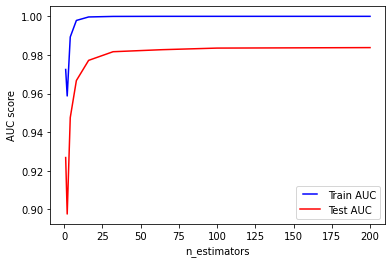

In [ ]:
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, "b", label="Train AUC")
line2, = plt.plot(n_estimators, test_results, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("n_estimators")
plt.show()

### Test max depth

In [ ]:
max_depths = np.linspace(1, 30, 30, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   print(max_depth)
   rf = RandomForestClassifier(max_depth=max_depth, max_features="sqrt", n_estimators = 20)
   rf.fit(X_train, y_train)
   train_pred = rf.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0


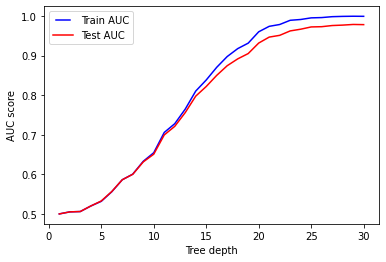

In [ ]:
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, "b", label="Train AUC")
line2, = plt.plot(max_depths, test_results, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("Tree depth")
plt.show()

## Selected RF
From the previous we select settings for our selected RF

In [ ]:
# Random Forest
rf = RandomForestClassifier(n_estimators=30, max_depth=30, max_features="sqrt")
# Train Decision Tree Classifer
rf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = rf.predict(X_test)

## Confusion matrix and classification report

In [ ]:
### Evaluation
print("Behaviour: "+ str(BEHAVIOUR))
print ("Windows_size: " + str(WIN_SIZE/2) +" sec " "(with overlap: "+ str(WIN_OVERLAP/2)+ " sec)")

results = confusion_matrix(y_test,y_pred)

print('Confusion Matrix Validation:')
print(results)
print('Accuracy Score : ', accuracy_score(y_test, y_pred))
print('Report : ')
print(classification_report(y_test, y_pred))

Behaviour: rumination_video
Windows_size: 120.0 sec (with overlap: 0.5 sec)
Confusion Matrix Validation:
[[104822     77]
 [   927  23452]]
Accuracy Score :  0.9922337907455252
Report : 
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    104899
           1       1.00      0.96      0.98     24379

    accuracy                           0.99    129278
   macro avg       0.99      0.98      0.99    129278
weighted avg       0.99      0.99      0.99    129278



##Feature Importances

In [ ]:
# feature importance
model = rf
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.02060
Feature: 1, Score: 0.03040
Feature: 2, Score: 0.03202
Feature: 3, Score: 0.03409
Feature: 4, Score: 0.04025
Feature: 5, Score: 0.08351
Feature: 6, Score: 0.07227
Feature: 7, Score: 0.06754
Feature: 8, Score: 0.06528
Feature: 9, Score: 0.06539
Feature: 10, Score: 0.02346
Feature: 11, Score: 0.02872
Feature: 12, Score: 0.02925
Feature: 13, Score: 0.02895
Feature: 14, Score: 0.03403
Feature: 15, Score: 0.08225
Feature: 16, Score: 0.06921
Feature: 17, Score: 0.06450
Feature: 18, Score: 0.06520
Feature: 19, Score: 0.06307
Feature: 20, Score: 0.00000
Feature: 21, Score: 0.00000
Feature: 22, Score: 0.00000
Feature: 23, Score: 0.00000
Feature: 24, Score: 0.00000
Feature: 25, Score: 0.00000
Feature: 26, Score: 0.00000
Feature: 27, Score: 0.00000
Feature: 28, Score: 0.00000
Feature: 29, Score: 0.00000


# Stratified cross validation rumination

In [ ]:
from sklearn.model_selection import StratifiedKFold
rf = RandomForestClassifier(n_estimators=25, max_depth=25, max_features="sqrt")
skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=True)
i=1

for train_index, test_index in skf.split(X_final, y_final):
  X_train, X_test = X_final[train_index], X_final[test_index]
  y_train, y_test = y_final[train_index], y_final[test_index]
  rf.fit(X_train,y_train)
# cross_validate also allows to specify metrics which you want to see
  print ("Windows size is "+ str(WIN_SIZE/2)+" seconds with overlap "+ str(WIN_OVERLAP/2)+ " seconds")
  print(confusion_matrix(y_test,rf.predict(X_test)))
  print(f"Accuracy for the fold no. {i} on the test set: {accuracy_score(y_test, rf.predict(X_test))}")
  print('Report : ')
  print(classification_report(y_test, rf.predict(X_test)))
  i += 1

Windows size is 120.0 seconds with overlap 0.5 seconds
[[69873    49]
 [  789 15474]]
Accuracy for the fold no. 1 on the test set: 0.9902767302894935
Report : 
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     69922
           1       1.00      0.95      0.97     16263

    accuracy                           0.99     86185
   macro avg       0.99      0.98      0.98     86185
weighted avg       0.99      0.99      0.99     86185

Windows size is 120.0 seconds with overlap 0.5 seconds
[[69859    63]
 [  770 15493]]
Accuracy for the fold no. 2 on the test set: 0.9903347450252364
Report : 
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     69922
           1       1.00      0.95      0.97     16263

    accuracy                           0.99     86185
   macro avg       0.99      0.98      0.98     86185
weighted avg       0.99      0.99      0.99     86185

Windows size is 120.0 seco

# Leave-out-one-animal rumination

In [ ]:
# Choose cow to leave out 7; 8; 21; 84.0
COW_NUMBER= 21

In [ ]:
# Choose cow to leave out 7; 8; 21; 84.0
COW_NUMBER= 7

In [ ]:
# Choose cow to leave out 7; 8; 21; 84.0
COW_NUMBER= 8

In [ ]:
# Choose cow to leave out 7; 8; 21; 84.0
COW_NUMBER= 25

In [ ]:
def choose_cow_to_leave_out(COW_NUMBER):
    result_train = np.stack(signal_features_1[signal_features_1[:,6] != COW_NUMBER], axis =0)
    result_test = np.stack(signal_features_1[signal_features_1[:,6] == COW_NUMBER], axis =0)
    return result_test, result_train

In [ ]:
result_test, result_train = choose_cow_to_leave_out(COW_NUMBER)

In [ ]:
#leave one cow out
y_train = np.stack(result_train[:,0], axis =0)
y_test = np.stack(result_test[:,0], axis =0)
X_train = np.stack(result_train[:,8], axis =0)
X_test = np.stack(result_test[:,8], axis =0)

##Selected RF

In [ ]:
rf = RandomForestClassifier(n_estimators=30, max_depth=30, max_features="sqrt")
rf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = rf.predict(X_test)

##Confusion matrix and classification report

In [ ]:
# Evaluation
print ("Evaluation RF validation with leave out cow_number "+ str(COW_NUMBER))
print("")
print("Behaviour: "+ str(BEHAVIOUR))
print ("Windows_size: " + str(WIN_SIZE/2) +" sec " "(with overlap: "+ str(WIN_OVERLAP/2)+ " sec)")

results = confusion_matrix(y_test,y_pred)

print('Confusion Matrix Validation:')
print(results)
print('Accuracy Score : ', accuracy_score(y_test, y_pred))
print('Report : ')
print(classification_report(y_test, y_pred))

Evaluation RF validation with leave out cow_number 25

Behaviour: rumination_video
Windows_size: 120.0 sec (with overlap: 0.5 sec)
Confusion Matrix Validation:
[[70204  8985]
 [10862  4704]]
Accuracy Score :  0.7905440346155875
Report : 
              precision    recall  f1-score   support

           0       0.87      0.89      0.88     79189
           1       0.34      0.30      0.32     15566

    accuracy                           0.79     94755
   macro avg       0.60      0.59      0.60     94755
weighted avg       0.78      0.79      0.79     94755



In [ ]:
# Evaluation
print ("Evaluation RF validation with leave out cow_number "+ str(COW_NUMBER))
print("")
print("Behaviour: "+ str(BEHAVIOUR))
print ("Windows_size: " + str(WIN_SIZE/2) +" sec " "(with overlap: "+ str(WIN_OVERLAP/2)+ " sec)")

results = confusion_matrix(y_test,y_pred)

print('Confusion Matrix Validation:')
print(results)
print('Accuracy Score : ', accuracy_score(y_test, y_pred))
print('Report : ')
print(classification_report(y_test, y_pred))

Evaluation RF validation with leave out cow_number 25

Behaviour: rumination_video
Windows_size: 120.0 sec (with overlap: 0.5 sec)
Confusion Matrix Validation:
[[69576  9613]
 [10574  4992]]
Accuracy Score :  0.7869558334652524
Report : 
              precision    recall  f1-score   support

           0       0.87      0.88      0.87     79189
           1       0.34      0.32      0.33     15566

    accuracy                           0.79     94755
   macro avg       0.60      0.60      0.60     94755
weighted avg       0.78      0.79      0.78     94755



In [ ]:
# Evaluation
print ("Evaluation RF validation with leave out cow_number "+ str(COW_NUMBER))
print("")
print("Behaviour: "+ str(BEHAVIOUR))
print ("Windows_size: " + str(WIN_SIZE/2) +" sec " "(with overlap: "+ str(WIN_OVERLAP/2)+ " sec)")

results = confusion_matrix(y_test,y_pred)

print('Confusion Matrix Validation:')
print(results)
print('Accuracy Score : ', accuracy_score(y_test, y_pred))
print('Report : ')
print(classification_report(y_test, y_pred))

Evaluation RF validation with leave out cow_number 21

Behaviour: rumination_video
Windows_size: 120.0 sec (with overlap: 0.5 sec)
Confusion Matrix Validation:
[[78838  7236]
 [ 7335  1156]]
Accuracy Score :  0.8459155078517422
Report : 
              precision    recall  f1-score   support

           0       0.91      0.92      0.92     86074
           1       0.14      0.14      0.14      8491

    accuracy                           0.85     94565
   macro avg       0.53      0.53      0.53     94565
weighted avg       0.85      0.85      0.85     94565



In [ ]:
# Evaluation
print ("Evaluation RF validation with leave out cow_number "+ str(COW_NUMBER))
print("")
print("Behaviour: "+ str(BEHAVIOUR))
print ("Windows_size: " + str(WIN_SIZE/2) +" sec " "(with overlap: "+ str(WIN_OVERLAP/2)+ " sec)")

results = confusion_matrix(y_test,y_pred)

print('Confusion Matrix Validation:')
print(results)
print('Accuracy Score : ', accuracy_score(y_test, y_pred))
print('Report : ')
print(classification_report(y_test, y_pred))

Evaluation RF validation with leave out cow_number 7

Behaviour: rumination_video
Windows_size: 120.0 sec (with overlap: 0.5 sec)
Confusion Matrix Validation:
[[97183  2704]
 [29441  5462]]
Accuracy Score :  0.7615179167594035
Report : 
              precision    recall  f1-score   support

           0       0.77      0.97      0.86     99887
           1       0.67      0.16      0.25     34903

    accuracy                           0.76    134790
   macro avg       0.72      0.56      0.56    134790
weighted avg       0.74      0.76      0.70    134790



# RandomForestAlgorithm Eating

In [ ]:
BEHAVIOUR='eating'

In [ ]:
y_final = np.stack(signal_features_1[:,1], axis =0) # BEHAVIOUR_2= 'eating_video'

In [ ]:
# Split dataset into trainingsset (70%) and testset (30%)
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.3, random_state=1)

## Test settings RandomForestAlgorithm

In [ ]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
train_results = []
test_results = []
for estimator in n_estimators:
   print(estimator)
   rf = RandomForestClassifier(n_estimators=estimator, max_features="sqrt")
   rf.fit(X_train, y_train)
   train_pred = rf.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

1
2
4
8
16
32
64
100
200


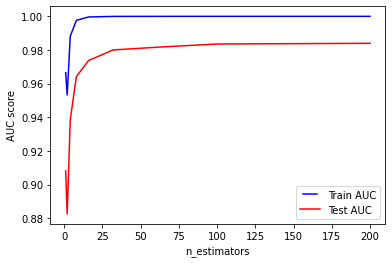

In [ ]:
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, "b", label="Train AUC")
line2, = plt.plot(n_estimators, test_results, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("n_estimators")
plt.show()

### Test max depth

In [ ]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   print(max_depth)
   rf = RandomForestClassifier(max_depth=max_depth, max_features="sqrt", n_estimators = 50)
   rf.fit(X_train, y_train)
   train_pred = rf.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0
31.0
32.0


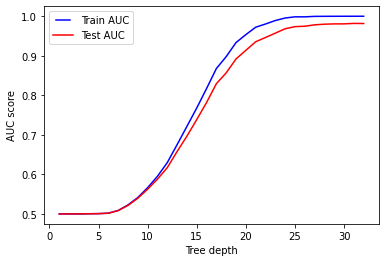

In [ ]:
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, "b", label="Train AUC")
line2, = plt.plot(max_depths, test_results, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("Tree depth")
plt.show()

## Selected RF
From the previous we select settings for our selected RF

In [ ]:
# Random Forest
rf = RandomForestClassifier(n_estimators=40, max_depth=25, max_features="sqrt")
# Train Decision Tree Classifer
rf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = rf.predict(X_test)

## Confusion matrix and classification report

In [ ]:
### Evaluation
print("Behaviour: "+ str(BEHAVIOUR))
print ("Windows_size: " + str(WIN_SIZE/2) +" sec " "(with overlap: "+ str(WIN_OVERLAP/2)+ " sec)")

results = confusion_matrix(y_test,y_pred)

print('Confusion Matrix Validation:')
print(results)
print('Accuracy Score : ', accuracy_score(y_test, y_pred))
print('Report : ')
print(classification_report(y_test, y_pred))

Behaviour: eating
Windows_size: 120.0 sec (with overlap: 0.5 sec)
Confusion Matrix Validation:
[[94810   197]
 [ 1872 32399]]
Accuracy Score :  0.9839957301319637
Report : 
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     95007
           1       0.99      0.95      0.97     34271

    accuracy                           0.98    129278
   macro avg       0.99      0.97      0.98    129278
weighted avg       0.98      0.98      0.98    129278



##Feature importances

In [ ]:
# feature importance
model = rf
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.02046
Feature: 1, Score: 0.03013
Feature: 2, Score: 0.03189
Feature: 3, Score: 0.03386
Feature: 4, Score: 0.04063
Feature: 5, Score: 0.08446
Feature: 6, Score: 0.07268
Feature: 7, Score: 0.06740
Feature: 8, Score: 0.06580
Feature: 9, Score: 0.06534
Feature: 10, Score: 0.02449
Feature: 11, Score: 0.02755
Feature: 12, Score: 0.02978
Feature: 13, Score: 0.02947
Feature: 14, Score: 0.03364
Feature: 15, Score: 0.08171
Feature: 16, Score: 0.06800
Feature: 17, Score: 0.06569
Feature: 18, Score: 0.06516
Feature: 19, Score: 0.06185
Feature: 20, Score: 0.00000
Feature: 21, Score: 0.00000
Feature: 22, Score: 0.00000
Feature: 23, Score: 0.00000
Feature: 24, Score: 0.00000
Feature: 25, Score: 0.00000
Feature: 26, Score: 0.00000
Feature: 27, Score: 0.00000
Feature: 28, Score: 0.00000
Feature: 29, Score: 0.00000


# RandomForestAlgorithm Resting

In [ ]:
BEHAVIOUR='resting'

In [ ]:
y_final = np.stack(signal_features_1[:,6], axis =0) # BEHAVIOUR_7= 'resting_video'

In [ ]:
# Split dataset into trainingsset (70%) and testset (30%)
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.3, random_state=1)

## Test settings RandomForestAlgorithm

In [ ]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
train_results = []
test_results = []
for estimator in n_estimators:
   print(estimator)
   rf = RandomForestClassifier(n_estimators=estimator, max_features="sqrt")
   rf.fit(X_train, y_train)
   train_pred = rf.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

1
2
4
8
16
32
64
100
200


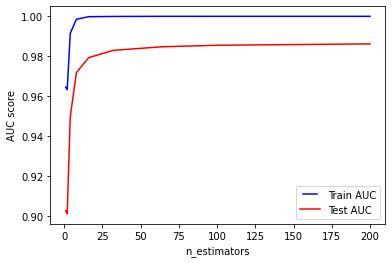

In [ ]:
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, "b", label="Train AUC")
line2, = plt.plot(n_estimators, test_results, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("n_estimators")
plt.show()

### Test max depth

In [ ]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   print(max_depth)
   rf = RandomForestClassifier(max_depth=max_depth, max_features="sqrt", n_estimators = 50)
   rf.fit(X_train, y_train)
   train_pred = rf.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0
31.0
32.0


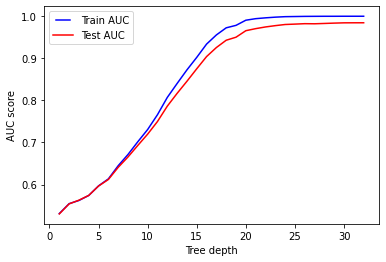

In [ ]:
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, "b", label="Train AUC")
line2, = plt.plot(max_depths, test_results, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("Tree depth")
plt.show()

## Selected RF
From the previous we select settings for our selected RF

In [ ]:
# Random Forest
rf = RandomForestClassifier(n_estimators=50, max_depth=25, max_features="sqrt")
# Train Decision Tree Classifer
rf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = rf.predict(X_test)

## Confusion matrix and classification report

In [ ]:
### Evaluation
print("Behaviour: "+ str(BEHAVIOUR))
print ("Windows_size: " + str(WIN_SIZE/2) +" sec " "(with overlap: "+ str(WIN_OVERLAP/2)+ " sec)")

results = confusion_matrix(y_test,y_pred)

print('Confusion Matrix Validation:')
print(results)
print('Accuracy Score : ', accuracy_score(y_test, y_pred))
print('Report : ')
print(classification_report(y_test, y_pred))

Behaviour: rumination_video
Windows_size: 120.0 sec (with overlap: 0.5 sec)
Confusion Matrix Validation:
[[64154  1393]
 [ 1178 62553]]
Accuracy Score :  0.9801126255047262
Report : 
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     65547
           1       0.98      0.98      0.98     63731

    accuracy                           0.98    129278
   macro avg       0.98      0.98      0.98    129278
weighted avg       0.98      0.98      0.98    129278



##Feature importances

In [ ]:
# feature importance
model = rf
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.02046
Feature: 1, Score: 0.03013
Feature: 2, Score: 0.03189
Feature: 3, Score: 0.03386
Feature: 4, Score: 0.04063
Feature: 5, Score: 0.08446
Feature: 6, Score: 0.07268
Feature: 7, Score: 0.06740
Feature: 8, Score: 0.06580
Feature: 9, Score: 0.06534
Feature: 10, Score: 0.02449
Feature: 11, Score: 0.02755
Feature: 12, Score: 0.02978
Feature: 13, Score: 0.02947
Feature: 14, Score: 0.03364
Feature: 15, Score: 0.08171
Feature: 16, Score: 0.06800
Feature: 17, Score: 0.06569
Feature: 18, Score: 0.06516
Feature: 19, Score: 0.06185
Feature: 20, Score: 0.00000
Feature: 21, Score: 0.00000
Feature: 22, Score: 0.00000
Feature: 23, Score: 0.00000
Feature: 24, Score: 0.00000
Feature: 25, Score: 0.00000
Feature: 26, Score: 0.00000
Feature: 27, Score: 0.00000
Feature: 28, Score: 0.00000
Feature: 29, Score: 0.00000


# RandomForestAlgorithm Mooing

In [ ]:
BEHAVIOUR_1= 'rumination_video'
BEHAVIOUR_2= 'eating_video'
BEHAVIOUR_3= 'drinking_video'
BEHAVIOUR_4= 'sleeping_video'
BEHAVIOUR_5= 'urinating_video'
BEHAVIOUR_6= 'mooing_video'
BEHAVIOUR_7= 'resting_video'

In [ ]:
BEHAVIOUR='mooing'

In [ ]:
y_final = np.stack(signal_features_1[:,5], axis =0) # BEHAVIOUR_5= 'mooing_video'

In [ ]:
# Split dataset into trainingsset (70%) and testset (30%)
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.3, random_state=1)

#Up and downsampling

In [ ]:
bool_minority_labels  = y_final != 0

In [ ]:
min_features = X_final[bool_minority_labels]
maj_features = X_final[~bool_minority_labels]

min_labels = y_final[bool_minority_labels]
maj_labels = y_final[~bool_minority_labels]

Split the minority class in 70 30 to have more in train set

In [ ]:
# Split minority dataset into training set and test set
X_min_train, X_min_test, y_min_train, y_min_test = train_test_split(min_features, min_labels, test_size=0.3, random_state=1) # 70% training and 30% test

Split the majority class in 50 50 so we can sample from independant sets

In [ ]:
# Split minority dataset into training set and test set
X_maj_train, X_maj_test, y_maj_train, y_maj_test = train_test_split(maj_features, maj_labels, test_size=0.5, random_state=1) # 50% training and 50% test

## Create train set

Upsample the amount of minority features and labels 3 times (why 3, no idea, feels that this will create enough labels)

In [ ]:
upsampled_X_min_train = np.concatenate([X_min_train, X_min_train, X_min_train], axis=0)
upsampled_y_min_train = np.concatenate([y_min_train, y_min_train, y_min_train], axis=0)

Downsample from 50% of the majority class to have same amount of samples

In [ ]:
ids = np.arange(len(X_maj_train))
choices = np.random.choice(ids, len(upsampled_X_min_train))

res_maj_train_features = X_maj_train[choices]
res_maj_train_labels = y_maj_train[choices]

res_maj_train_features.shape

(6648, 30)

Concat together

In [ ]:
resampled_train_features = np.concatenate([upsampled_X_min_train, res_maj_train_features], axis=0)
resampled_train_labels = np.concatenate([upsampled_y_min_train, res_maj_train_labels], axis=0)

Shuffle

In [ ]:
order = np.arange(len(resampled_train_labels))
np.random.shuffle(order)
resampled_train_features = resampled_train_features[order]
resampled_train_labels = resampled_train_labels[order]

## Create test set

We start from the X_min_test

And downsample the remaining part of the majority class which we didn't use so far

In [ ]:
ids = np.arange(len(X_maj_test))
choices = np.random.choice(ids, len(X_min_test))

res_maj_test_features = X_maj_test[choices]
res_maj_test_labels = y_maj_test[choices]


Concat

In [ ]:
resampled_test_features = np.concatenate([X_min_test, res_maj_test_features], axis=0)
resampled_test_labels = np.concatenate([y_min_test, res_maj_test_labels], axis=0)

Shuffle

In [ ]:
order = np.arange(len(resampled_test_labels))
np.random.shuffle(order)
resampled_test_features = resampled_test_features[order]
resampled_test_labels = resampled_test_labels[order]

In [ ]:
X_train= resampled_train_features
y_train= resampled_train_labels
X_test=  resampled_test_features
y_test=  resampled_test_labels

## Test settings RandomForestAlgorithm

In [ ]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
train_results = []
test_results = []
for estimator in n_estimators:
   print(estimator)
   rf = RandomForestClassifier(n_estimators=estimator, max_features="sqrt")
   rf.fit(X_train, y_train)
   train_pred = rf.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

1
2
4
8
16
32
64
100
200


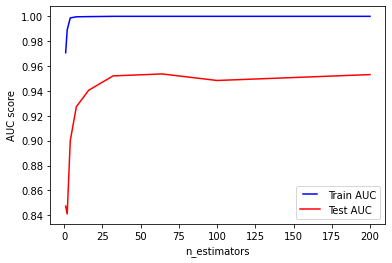

In [ ]:
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, "b", label="Train AUC")
line2, = plt.plot(n_estimators, test_results, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("n_estimators")
plt.show()

### Test max depth

In [ ]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   print(max_depth)
   rf = RandomForestClassifier(max_depth=max_depth, max_features="sqrt", n_estimators = 50)
   rf.fit(X_train, y_train)
   train_pred = rf.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0
31.0
32.0


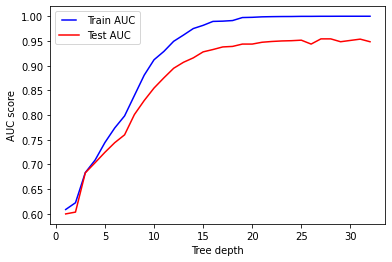

In [ ]:
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, "b", label="Train AUC")
line2, = plt.plot(max_depths, test_results, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("Tree depth")
plt.show()

## Selected RF
From the previous we select settings for our selected RF

In [ ]:
# Random Forest
rf = RandomForestClassifier(n_estimators=25, max_depth=20, max_features="sqrt")
# Train Decision Tree Classifer
rf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = rf.predict(X_test)

## Confusion matrix and classification report

## without resampling

## Test settings RandomForestAlgorithm

In [ ]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
train_results = []
test_results = []
for estimator in n_estimators:
   print(estimator)
   rf = RandomForestClassifier(n_estimators=estimator, max_features="sqrt")
   rf.fit(X_train, y_train)
   train_pred = rf.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

1
2
4
8
16
32
64
100
200


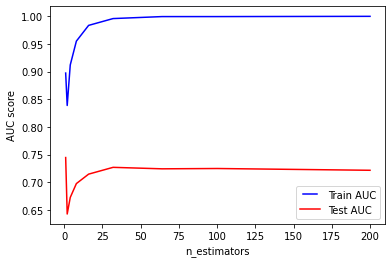

In [ ]:
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, "b", label="Train AUC")
line2, = plt.plot(n_estimators, test_results, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("n_estimators")
plt.show()

### Test max depth

In [ ]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   print(max_depth)
   rf = RandomForestClassifier(max_depth=max_depth, max_features="sqrt", n_estimators = 50)
   rf.fit(X_train, y_train)
   train_pred = rf.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0
31.0
32.0


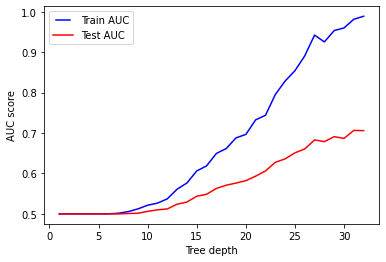

In [ ]:
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, "b", label="Train AUC")
line2, = plt.plot(max_depths, test_results, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("Tree depth")
plt.show()

In [ ]:
### Evaluation
print("Behaviour: "+ str(BEHAVIOUR))
print ("Windows_size: " + str(WIN_SIZE/2) +" sec " "(with overlap: "+ str(WIN_OVERLAP/2)+ " sec)")

results = confusion_matrix(y_test,y_pred)

print('Confusion Matrix Validation:')
print(results)
print('Accuracy Score : ', accuracy_score(y_test, y_pred))
print('Report : ')
print(classification_report(y_test, y_pred))

Behaviour: mooing
Windows_size: 120.0 sec (with overlap: 0.5 sec)
Confusion Matrix Validation:
[[128327     15]
 [   778    158]]
Accuracy Score :  0.9938659323318739
Report : 
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    128342
           1       0.91      0.17      0.28       936

    accuracy                           0.99    129278
   macro avg       0.95      0.58      0.64    129278
weighted avg       0.99      0.99      0.99    129278



## with resaampling

In [ ]:
### Evaluation
print("Behaviour: "+ str(BEHAVIOUR))
print ("Windows_size: " + str(WIN_SIZE/2) +" sec " "(with overlap: "+ str(WIN_OVERLAP/2)+ " sec)")

results = confusion_matrix(y_test,y_pred)

print('Confusion Matrix Validation:')
print(results)
print('Accuracy Score : ', accuracy_score(y_test, y_pred))
print('Report : ')
print(classification_report(y_test, y_pred))

Behaviour: mooing
Windows_size: 120.0 sec (with overlap: 0.5 sec)
Confusion Matrix Validation:
[[909  41]
 [ 73 877]]
Accuracy Score :  0.94
Report : 
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       950
           1       0.96      0.92      0.94       950

    accuracy                           0.94      1900
   macro avg       0.94      0.94      0.94      1900
weighted avg       0.94      0.94      0.94      1900



In [ ]:
# feature importance
model = rf
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.01592
Feature: 1, Score: 0.02538
Feature: 2, Score: 0.02926
Feature: 3, Score: 0.03384
Feature: 4, Score: 0.03788
Feature: 5, Score: 0.08007
Feature: 6, Score: 0.06814
Feature: 7, Score: 0.06643
Feature: 8, Score: 0.06666
Feature: 9, Score: 0.06630
Feature: 10, Score: 0.01729
Feature: 11, Score: 0.02487
Feature: 12, Score: 0.02559
Feature: 13, Score: 0.03034
Feature: 14, Score: 0.03188
Feature: 15, Score: 0.07919
Feature: 16, Score: 0.06715
Feature: 17, Score: 0.06396
Feature: 18, Score: 0.07723
Feature: 19, Score: 0.09262
Feature: 20, Score: 0.00000
Feature: 21, Score: 0.00000
Feature: 22, Score: 0.00000
Feature: 23, Score: 0.00000
Feature: 24, Score: 0.00000
Feature: 25, Score: 0.00000
Feature: 26, Score: 0.00000
Feature: 27, Score: 0.00000
Feature: 28, Score: 0.00000
Feature: 29, Score: 0.00000


# RandomForestAlgorithm Urinating

In [ ]:
BEHAVIOUR_1= 'rumination_video'
BEHAVIOUR_2= 'eating_video'
BEHAVIOUR_3= 'drinking_video'
BEHAVIOUR_4= 'sleeping_video'
BEHAVIOUR_5= 'urinating_video'
BEHAVIOUR_6= 'mooing_video'
BEHAVIOUR_7= 'resting_video'

In [ ]:
BEHAVIOUR='urinating'

In [ ]:
y_final = np.stack(signal_features_1[:,4], axis =0) # BEHAVIOUR_5= 'urinating_video'

In [ ]:
bool_minority_labels  = y_final != 0

In [ ]:
min_features = X_final[bool_minority_labels]
maj_features = X_final[~bool_minority_labels]

min_labels = y_final[bool_minority_labels]
maj_labels = y_final[~bool_minority_labels]

Split the minority class in 70 30 to have more in train set

In [ ]:
# Split minority dataset into training set and test set
X_min_train, X_min_test, y_min_train, y_min_test = train_test_split(min_features, min_labels, test_size=0.3, random_state=1) # 70% training and 30% test

Split the majority class in 50 50 so we can sample from independant sets

In [ ]:
# Split minority dataset into training set and test set
X_maj_train, X_maj_test, y_maj_train, y_maj_test = train_test_split(maj_features, maj_labels, test_size=0.5, random_state=1) # 50% training and 50% test

## Create train set

Upsample the amount of minority features and labels 3 times (why 3, no idea, feels that this will create enough labels)

In [ ]:
upsampled_X_min_train = np.concatenate([X_min_train, X_min_train, X_min_train], axis=0)
upsampled_y_min_train = np.concatenate([y_min_train, y_min_train, y_min_train], axis=0)

Downsample from 50% of the majority class to have same amount of samples

In [ ]:
ids = np.arange(len(X_maj_train))
choices = np.random.choice(ids, len(upsampled_X_min_train))

res_maj_train_features = X_maj_train[choices]
res_maj_train_labels = y_maj_train[choices]

res_maj_train_features.shape

(2322, 30)

Concat together

In [ ]:
resampled_train_features = np.concatenate([upsampled_X_min_train, res_maj_train_features], axis=0)
resampled_train_labels = np.concatenate([upsampled_y_min_train, res_maj_train_labels], axis=0)

Shuffle

In [ ]:
order = np.arange(len(resampled_train_labels))
np.random.shuffle(order)
resampled_train_features = resampled_train_features[order]
resampled_train_labels = resampled_train_labels[order]

## Create test set

We start from the X_min_test

And downsample the remaining part of the majority class which we didn't use so far

In [ ]:
ids = np.arange(len(X_maj_test))
choices = np.random.choice(ids, len(X_min_test))

res_maj_test_features = X_maj_test[choices]
res_maj_test_labels = y_maj_test[choices]


Concat

In [ ]:
resampled_test_features = np.concatenate([X_min_test, res_maj_test_features], axis=0)
resampled_test_labels = np.concatenate([y_min_test, res_maj_test_labels], axis=0)

Shuffle

In [ ]:
order = np.arange(len(resampled_test_labels))
np.random.shuffle(order)
resampled_test_features = resampled_test_features[order]
resampled_test_labels = resampled_test_labels[order]

In [ ]:
X_train= resampled_train_features
y_train= resampled_train_labels
X_test=  resampled_test_features
y_test=  resampled_test_labels

## Test settings RandomForestAlgorithm

In [ ]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
train_results = []
test_results = []
for estimator in n_estimators:
   print(estimator)
   rf = RandomForestClassifier(n_estimators=estimator, max_features="sqrt")
   rf.fit(X_train, y_train)
   train_pred = rf.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

1
2
4
8
16
32
64
100
200


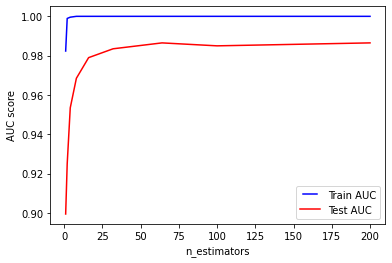

In [ ]:
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, "b", label="Train AUC")
line2, = plt.plot(n_estimators, test_results, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("n_estimators")
plt.show()

### Test max depth

In [ ]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   print(max_depth)
   rf = RandomForestClassifier(max_depth=max_depth, max_features="sqrt", n_estimators = 50)
   rf.fit(X_train, y_train)
   train_pred = rf.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0
31.0
32.0


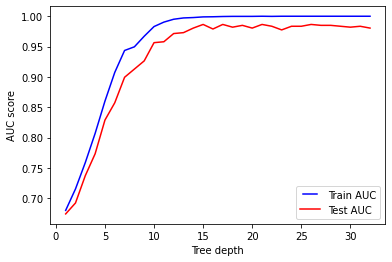

In [ ]:
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, "b", label="Train AUC")
line2, = plt.plot(max_depths, test_results, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("Tree depth")
plt.show()

## Selected RF
From the previous we select settings for our selected RF

In [ ]:
# Random Forest
rf = RandomForestClassifier(n_estimators=50, max_depth=15, max_features="sqrt")
# Train Decision Tree Classifer
rf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = rf.predict(X_test)

## Confusion matrix and classification report

without resampling

In [ ]:
### Evaluation
print("Behaviour: "+ str(BEHAVIOUR))
print ("Windows_size: " + str(WIN_SIZE/2) +" sec " "(with overlap: "+ str(WIN_OVERLAP/2)+ " sec)")

results = confusion_matrix(y_test,y_pred)

print('Confusion Matrix Validation:')
print(results)
print('Accuracy Score : ', accuracy_score(y_test, y_pred))
print('Report : ')
print(classification_report(y_test, y_pred))

Behaviour: urinating
Windows_size: 120.0 sec (with overlap: 0.5 sec)
Confusion Matrix Validation:
[[128334      8]
 [   855     81]]
Accuracy Score :  0.9933244635591516
Report : 
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    128342
           1       0.91      0.09      0.16       936

    accuracy                           0.99    129278
   macro avg       0.95      0.54      0.58    129278
weighted avg       0.99      0.99      0.99    129278



with resampling

In [ ]:
### Evaluation
print("Behaviour: "+ str(BEHAVIOUR))
print ("Windows_size: " + str(WIN_SIZE/2) +" sec " "(with overlap: "+ str(WIN_OVERLAP/2)+ " sec)")

results = confusion_matrix(y_test,y_pred)

print('Confusion Matrix Validation:')
print(results)
print('Accuracy Score : ', accuracy_score(y_test, y_pred))
print('Report : ')
print(classification_report(y_test, y_pred))

Behaviour: urinating
Windows_size: 120.0 sec (with overlap: 0.5 sec)
Confusion Matrix Validation:
[[330   3]
 [ 10 323]]
Accuracy Score :  0.9804804804804805
Report : 
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       333
           1       0.99      0.97      0.98       333

    accuracy                           0.98       666
   macro avg       0.98      0.98      0.98       666
weighted avg       0.98      0.98      0.98       666



##Feature importances

In [ ]:
# feature importance
model = rf
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.03025
Feature: 1, Score: 0.04197
Feature: 2, Score: 0.03687
Feature: 3, Score: 0.03050
Feature: 4, Score: 0.05664
Feature: 5, Score: 0.08549
Feature: 6, Score: 0.09199
Feature: 7, Score: 0.07974
Feature: 8, Score: 0.06275
Feature: 9, Score: 0.05362
Feature: 10, Score: 0.02258
Feature: 11, Score: 0.02659
Feature: 12, Score: 0.02583
Feature: 13, Score: 0.02239
Feature: 14, Score: 0.02241
Feature: 15, Score: 0.06408
Feature: 16, Score: 0.10550
Feature: 17, Score: 0.05459
Feature: 18, Score: 0.04518
Feature: 19, Score: 0.04102
Feature: 20, Score: 0.00000
Feature: 21, Score: 0.00000
Feature: 22, Score: 0.00000
Feature: 23, Score: 0.00000
Feature: 24, Score: 0.00000
Feature: 25, Score: 0.00000
Feature: 26, Score: 0.00000
Feature: 27, Score: 0.00000
Feature: 28, Score: 0.00000
Feature: 29, Score: 0.00000


# RandomForestAlgorithm Drinking

In [ ]:
BEHAVIOUR='drinking'

In [ ]:
y_final = np.stack(signal_features_1[:,2], axis =0) # BEHAVIOUR_3= 'drinking_video'

In [ ]:
bool_minority_labels  = y_final != 0

In [ ]:
min_features = X_final[bool_minority_labels]
maj_features = X_final[~bool_minority_labels]

min_labels = y_final[bool_minority_labels]
maj_labels = y_final[~bool_minority_labels]

Split the minority class in 70 30 to have more in train set

In [ ]:
# Split minority dataset into training set and test set
X_min_train, X_min_test, y_min_train, y_min_test = train_test_split(min_features, min_labels, test_size=0.3, random_state=1) # 70% training and 30% test

Split the majority class in 50 50 so we can sample from independant sets

In [ ]:
# Split minority dataset into training set and test set
X_maj_train, X_maj_test, y_maj_train, y_maj_test = train_test_split(maj_features, maj_labels, test_size=0.5, random_state=1) # 50% training and 50% test

## Create train set

Upsample the amount of minority features and labels 3 times (why 3, no idea, feels that this will create enough labels)

In [ ]:
upsampled_X_min_train = np.concatenate([X_min_train, X_min_train, X_min_train], axis=0)
upsampled_y_min_train = np.concatenate([y_min_train, y_min_train, y_min_train], axis=0)

Downsample from 50% of the majority class to have same amount of samples

In [ ]:
ids = np.arange(len(X_maj_train))
choices = np.random.choice(ids, len(upsampled_X_min_train))

res_maj_train_features = X_maj_train[choices]
res_maj_train_labels = y_maj_train[choices]

res_maj_train_features.shape

(9630, 30)

Concat together

In [ ]:
resampled_train_features = np.concatenate([upsampled_X_min_train, res_maj_train_features], axis=0)
resampled_train_labels = np.concatenate([upsampled_y_min_train, res_maj_train_labels], axis=0)

Shuffle

In [ ]:
order = np.arange(len(resampled_train_labels))
np.random.shuffle(order)
resampled_train_features = resampled_train_features[order]
resampled_train_labels = resampled_train_labels[order]

## Create test set

We start from the X_min_test

And downsample the remaining part of the majority class which we didn't use so far

In [ ]:
ids = np.arange(len(X_maj_test))
choices = np.random.choice(ids, len(X_min_test))

res_maj_test_features = X_maj_test[choices]
res_maj_test_labels = y_maj_test[choices]


Concat

In [ ]:
resampled_test_features = np.concatenate([X_min_test, res_maj_test_features], axis=0)
resampled_test_labels = np.concatenate([y_min_test, res_maj_test_labels], axis=0)

Shuffle

In [ ]:
order = np.arange(len(resampled_test_labels))
np.random.shuffle(order)
resampled_test_features = resampled_test_features[order]
resampled_test_labels = resampled_test_labels[order]

In [ ]:
X_train= resampled_train_features
y_train= resampled_train_labels
X_test=  resampled_test_features
y_test=  resampled_test_labels

## Test settings RandomForestAlgorithm

In [ ]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
train_results = []
test_results = []
for estimator in n_estimators:
   print(estimator)
   rf = RandomForestClassifier(n_estimators=estimator, max_features="sqrt")
   rf.fit(X_train, y_train)
   train_pred = rf.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

1
2
4
8
16
32
64
100
200


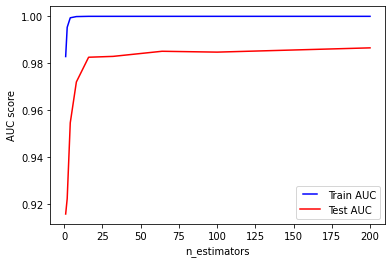

In [ ]:
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, "b", label="Train AUC")
line2, = plt.plot(n_estimators, test_results, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("n_estimators")
plt.show()

### Test max depth

In [ ]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   print(max_depth)
   rf = RandomForestClassifier(max_depth=max_depth, max_features="sqrt", n_estimators = 50)
   rf.fit(X_train, y_train)
   train_pred = rf.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0
31.0
32.0


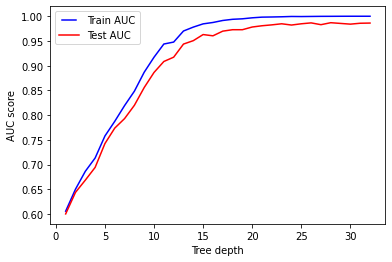

In [ ]:
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, "b", label="Train AUC")
line2, = plt.plot(max_depths, test_results, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("Tree depth")
plt.show()

## Selected RF
From the previous we select settings for our selected RF

In [ ]:
# Random Forest
rf = RandomForestClassifier(n_estimators=50, max_depth=20, max_features="sqrt")
# Train Decision Tree Classifer
rf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = rf.predict(X_test)

## Confusion matrix and classification report

without resampling

In [ ]:
### Evaluation
print("Behaviour: "+ str(BEHAVIOUR))
print ("Windows_size: " + str(WIN_SIZE/2) +" sec " "(with overlap: "+ str(WIN_OVERLAP/2)+ " sec)")

results = confusion_matrix(y_test,y_pred)

print('Confusion Matrix Validation:')
print(results)
print('Accuracy Score : ', accuracy_score(y_test, y_pred))
print('Report : ')
print(classification_report(y_test, y_pred))

Behaviour: drinking
Windows_size: 120.0 sec (with overlap: 0.5 sec)
Confusion Matrix Validation:
[[128321     21]
 [   767    169]]
Accuracy Score :  0.9939046086727826
Report : 
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    128342
           1       0.89      0.18      0.30       936

    accuracy                           0.99    129278
   macro avg       0.94      0.59      0.65    129278
weighted avg       0.99      0.99      0.99    129278



with resampling

In [ ]:
### Evaluation
print("Behaviour: "+ str(BEHAVIOUR))
print ("Windows_size: " + str(WIN_SIZE/2) +" sec " "(with overlap: "+ str(WIN_OVERLAP/2)+ " sec)")

results = confusion_matrix(y_test,y_pred)

print('Confusion Matrix Validation:')
print(results)
print('Accuracy Score : ', accuracy_score(y_test, y_pred))
print('Report : ')
print(classification_report(y_test, y_pred))

Behaviour: urinating
Windows_size: 120.0 sec (with overlap: 0.5 sec)
Confusion Matrix Validation:
[[1345   32]
 [  22 1355]]
Accuracy Score :  0.9803921568627451
Report : 
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1377
           1       0.98      0.98      0.98      1377

    accuracy                           0.98      2754
   macro avg       0.98      0.98      0.98      2754
weighted avg       0.98      0.98      0.98      2754



##Feature importances

In [ ]:
# feature importance
model = rf
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.02776
Feature: 1, Score: 0.03776
Feature: 2, Score: 0.03499
Feature: 3, Score: 0.03949
Feature: 4, Score: 0.04147
Feature: 5, Score: 0.07690
Feature: 6, Score: 0.07953
Feature: 7, Score: 0.07173
Feature: 8, Score: 0.06008
Feature: 9, Score: 0.06335
Feature: 10, Score: 0.02206
Feature: 11, Score: 0.02496
Feature: 12, Score: 0.02930
Feature: 13, Score: 0.03450
Feature: 14, Score: 0.03014
Feature: 15, Score: 0.08406
Feature: 16, Score: 0.06953
Feature: 17, Score: 0.05956
Feature: 18, Score: 0.05674
Feature: 19, Score: 0.05608
Feature: 20, Score: 0.00000
Feature: 21, Score: 0.00000
Feature: 22, Score: 0.00000
Feature: 23, Score: 0.00000
Feature: 24, Score: 0.00000
Feature: 25, Score: 0.00000
Feature: 26, Score: 0.00000
Feature: 27, Score: 0.00000
Feature: 28, Score: 0.00000
Feature: 29, Score: 0.00000


# RandomForestAlgorithm Sleeping

In [ ]:
BEHAVIOUR='sleeping'

In [ ]:
y_final = np.stack(signal_features_1[:,3], axis =0) # BEHAVIOUR_1= 'rumination_video'

In [ ]:
bool_minority_labels  = y_final != 0

In [ ]:
min_features = X_final[bool_minority_labels]
maj_features = X_final[~bool_minority_labels]

min_labels = y_final[bool_minority_labels]
maj_labels = y_final[~bool_minority_labels]

Split the minority class in 70 30 to have more in train set

In [ ]:
# Split minority dataset into training set and test set
X_min_train, X_min_test, y_min_train, y_min_test = train_test_split(min_features, min_labels, test_size=0.3, random_state=1) # 70% training and 30% test

Split the majority class in 50 50 so we can sample from independant sets

In [ ]:
# Split minority dataset into training set and test set
X_maj_train, X_maj_test, y_maj_train, y_maj_test = train_test_split(maj_features, maj_labels, test_size=0.5, random_state=1) # 50% training and 50% test

## Create train set

Upsample the amount of minority features and labels 3 times (why 3, no idea, feels that this will create enough labels)

In [ ]:
upsampled_X_min_train = np.concatenate([X_min_train, X_min_train, X_min_train], axis=0)
upsampled_y_min_train = np.concatenate([y_min_train, y_min_train, y_min_train], axis=0)

Downsample from 50% of the majority class to have same amount of samples

In [ ]:
ids = np.arange(len(X_maj_train))
choices = np.random.choice(ids, len(upsampled_X_min_train))

res_maj_train_features = X_maj_train[choices]
res_maj_train_labels = y_maj_train[choices]

res_maj_train_features.shape

(7125, 30)

Concat together

In [ ]:
resampled_train_features = np.concatenate([upsampled_X_min_train, res_maj_train_features], axis=0)
resampled_train_labels = np.concatenate([upsampled_y_min_train, res_maj_train_labels], axis=0)

Shuffle

In [ ]:
order = np.arange(len(resampled_train_labels))
np.random.shuffle(order)
resampled_train_features = resampled_train_features[order]
resampled_train_labels = resampled_train_labels[order]

## Create test set

We start from the X_min_test

And downsample the remaining part of the majority class which we didn't use so far

In [ ]:
ids = np.arange(len(X_maj_test))
choices = np.random.choice(ids, len(X_min_test))

res_maj_test_features = X_maj_test[choices]
res_maj_test_labels = y_maj_test[choices]


Concat

In [ ]:
resampled_test_features = np.concatenate([X_min_test, res_maj_test_features], axis=0)
resampled_test_labels = np.concatenate([y_min_test, res_maj_test_labels], axis=0)

Shuffle

In [ ]:
order = np.arange(len(resampled_test_labels))
np.random.shuffle(order)
resampled_test_features = resampled_test_features[order]
resampled_test_labels = resampled_test_labels[order]

In [ ]:
X_train= resampled_train_features
y_train= resampled_train_labels
X_test=  resampled_test_features
y_test=  resampled_test_labels

## Test settings RandomForestAlgorithm


### Test number of trees
Adopted from https://medium.com/all-things-ai/in-depth-parameter-tuning-for-random-forest-d67bb7e920d

In [ ]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
train_results = []
test_results = []
for estimator in n_estimators:
   print(estimator)
   rf = RandomForestClassifier(n_estimators=estimator, max_features="sqrt")
   rf.fit(X_train, y_train)
   train_pred = rf.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

1
2
4
8
16
32
64
100
200


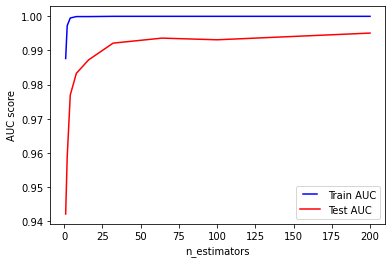

In [ ]:
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, "b", label="Train AUC")
line2, = plt.plot(n_estimators, test_results, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("n_estimators")
plt.show()

### Test max depth

In [ ]:
max_depths = np.linspace(1, 30, 30, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   print(max_depth)
   rf = RandomForestClassifier(max_depth=max_depth, max_features="sqrt", n_estimators = 20)
   rf.fit(X_train, y_train)
   train_pred = rf.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0


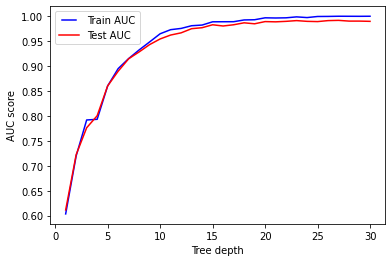

In [ ]:
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, "b", label="Train AUC")
line2, = plt.plot(max_depths, test_results, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("Tree depth")
plt.show()

## Selected RF
From the previous we select settings for our selected RF

In [ ]:
# Random Forest
rf = RandomForestClassifier(n_estimators=30, max_depth=25, max_features="sqrt")
# Train Decision Tree Classifer
rf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = rf.predict(X_test)

## Confusion matrix and classification report

without resampling

In [ ]:
### Evaluation
print("Behaviour: "+ str(BEHAVIOUR))
print ("Windows_size: " + str(WIN_SIZE/2) +" sec " "(with overlap: "+ str(WIN_OVERLAP/2)+ " sec)")

results = confusion_matrix(y_test,y_pred)

print('Confusion Matrix Validation:')
print(results)
print('Accuracy Score : ', accuracy_score(y_test, y_pred))
print('Report : ')
print(classification_report(y_test, y_pred))

Behaviour: sleeping
Windows_size: 120.0 sec (with overlap: 0.5 sec)
Confusion Matrix Validation:
[[128317     25]
 [   635    301]]
Accuracy Score :  0.9948947230000464
Report : 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    128342
           1       0.92      0.32      0.48       936

    accuracy                           0.99    129278
   macro avg       0.96      0.66      0.74    129278
weighted avg       0.99      0.99      0.99    129278



with resampling

In [ ]:
### Evaluation
print("Behaviour: "+ str(BEHAVIOUR))
print ("Windows_size: " + str(WIN_SIZE/2) +" sec " "(with overlap: "+ str(WIN_OVERLAP/2)+ " sec)")

results = confusion_matrix(y_test,y_pred)

print('Confusion Matrix Validation:')
print(results)
print('Accuracy Score : ', accuracy_score(y_test, y_pred))
print('Report : ')
print(classification_report(y_test, y_pred))

Behaviour: sleeping
Windows_size: 120.0 sec (with overlap: 0.5 sec)
Confusion Matrix Validation:
[[1014    5]
 [   9 1010]]
Accuracy Score :  0.9931305201177625
Report : 
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1019
           1       1.00      0.99      0.99      1019

    accuracy                           0.99      2038
   macro avg       0.99      0.99      0.99      2038
weighted avg       0.99      0.99      0.99      2038



In [ ]:
# feature importance
model = rf
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.02129
Feature: 1, Score: 0.04114
Feature: 2, Score: 0.02506
Feature: 3, Score: 0.03261
Feature: 4, Score: 0.05568
Feature: 5, Score: 0.07470
Feature: 6, Score: 0.10356
Feature: 7, Score: 0.06482
Feature: 8, Score: 0.05784
Feature: 9, Score: 0.05600
Feature: 10, Score: 0.01779
Feature: 11, Score: 0.02446
Feature: 12, Score: 0.02423
Feature: 13, Score: 0.03230
Feature: 14, Score: 0.03214
Feature: 15, Score: 0.06984
Feature: 16, Score: 0.07154
Feature: 17, Score: 0.06244
Feature: 18, Score: 0.06634
Feature: 19, Score: 0.06623
Feature: 20, Score: 0.00000
Feature: 21, Score: 0.00000
Feature: 22, Score: 0.00000
Feature: 23, Score: 0.00000
Feature: 24, Score: 0.00000
Feature: 25, Score: 0.00000
Feature: 26, Score: 0.00000
Feature: 27, Score: 0.00000
Feature: 28, Score: 0.00000
Feature: 29, Score: 0.00000


# Descriptives

## Counting data PeakDetectionAlgorithm

In [ ]:
final_data_peak_detection.count()

##Counting data RandomForestAlgorithm

In [ ]:
final_data_rf.count()

## Number of observations video per behavior

In [ ]:
np.unique(final_data_peak_detection['behaviour'], return_counts=True)

## Number of observations video per animal

In [ ]:
np.unique(final_data_peak_detection['cow_number'], return_counts=True)

## Time between two contraction cycles

In [ ]:
final_data_rum= final_data_peak_detection[final_data_peak_detection.behaviour==1]
final_data_eat= final_data_peak_detection[final_data_peak_detection.behaviour==2]
final_data_drink= final_data_peak_detection[final_data_peak_detection.behaviour==3]
final_data_sleep= final_data_peak_detection[final_data_peak_detection.behaviour==4]
final_data_other= final_data_peak_detection[final_data_peak_detection.behaviour==5]

print("Time between contraction cycles during rumination:")
print("mean:"+str(final_data_rum['low_time'].mean()))
print("std:"+str(final_data_rum['low_time'].std()))
print("median:"+str(final_data_rum['low_time'].median()))
print("iqr:"+ str(iqr(final_data_rum['low_time']))+"\n")

print("Time between contraction cycles during eating:")
print("mean:"+str(final_data_eat['low_time'].mean()))
print("std:"+str(final_data_eat['low_time'].std()))
print("median:"+str(final_data_eat['low_time'].median()))
print("iqr:"+ str(iqr(final_data_eat['low_time']))+"\n")

print("Time between contraction cycles during drinking:")
print("mean:"+str(final_data_drink['low_time'].mean()))
print("std:"+str(final_data_drink['low_time'].std()))
print("median:"+str(final_data_drink['low_time'].median()))
print("iqr:"+ str(iqr(final_data_drink['low_time']))+"\n")

print("Time between contraction cycles during sleeping:")
print("mean:"+str(final_data_sleep['low_time'].mean()))
print("std:"+str(final_data_sleep['low_time'].std()))
print("median:"+str(final_data_sleep['low_time'].median()))
print("iqr:"+ str(iqr(final_data_sleep['low_time']))+"\n")

print("Time between contraction cycles during other behaviour:")
print("mean:"+str(final_data_other['low_time'].mean()))
print("std:"+str(final_data_other['low_time'].std()))
print("median:"+str(final_data_other['low_time'].median()))
print("iqr:"+ str(iqr(final_data_other['low_time']))+"\n")

## Boxplots of time between two contraction cycles

In [ ]:
sns.boxplot(x="behaviour", y="low_time",orient='v', data=final_data_peak_detection_corrected, showfliers=False)
plt.xlabel('Behaviour')
plt.ylabel('Time interval between contractions (s)')
plt.show()

## GLM model eating and rumination

In [ ]:
#create csv for GLM model
final_data_HK_EAT_REST = final_data_peak_detection_corrected[final_data_peak_detection_corrected.behaviour<3.0]
final_data_HK_EAT= final_data_HK_EAT_REST[final_data_peak_detection_corrected.behaviour>=1.0]
result_file='/content/gdrive/Shared drives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectPicoLog/data/out/final_data_HK_EAT.csv'
final_data_HK_EAT.to_csv(result_file)

In [ ]:
%load_ext rpy2.ipython

In [ ]:
%%R
url = ('/content/gdrive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectPicoLog/data/out/final_data_HK_EAT.csv')
dataset = read.csv(url)

In [ ]:
%%R
package_list <- c("dplyr",
                  "lme4"
                  )

for (pkg in package_list) {
  if (pkg %in% rownames(installed.packages()) == FALSE)
  {install.packages(pkg, dependencies = TRUE)}
  if (pkg %in% rownames(.packages()) == FALSE)
  {library(pkg, character.only = TRUE)}
  print(citation(pkg))

}

In [ ]:
%%R
install.packages("lmerTest", dependencies = TRUE)
library ("lmerTest")

In [ ]:
%%R
gl<- glm('low_time ~ factor(behaviour)+factor(cow_number)', data = dataset, family = gaussian)
summary(gl)